This notebook looks at the Lorenz Model III as described in Lorenz, 2005.
This model has a long and short scale that interact with eachother.
The state variable is $Z$ and contains both scales.
$Z$ is smoothed using a window defined by $I$ and weights defined by $\alpha$ and $\beta$, generating the variable $X$ which contains the long scales.
The variable $Y$ contains the short scales and is equal to $Z - X$.

The time derivative of $Z$ is very simmilar to the Lorenz-96 model:
$$
d Z_n/dt = [X, X]_{K, n} + b^2 [Y, Y]_{1, n} + c[Y, X]_{1, n} - X_n - bY_n + F
$$
$$
X_n = \sum_{i = -I}^I (\alpha - \beta |i|) Z_{n + i}
$$
Where the above has the first and last terms divided by 2.
$$
Y_n = Z_n - X_n
$$
$$
[X, Y]_{K, n} = \sum_{j=-J}^{J}\sum_{i=-J}^{J}( -X_{n - 2K - i}Y_{n-K-j} + X_{n - K + j - i}Y_{n + K + j})/K^2
$$
For an odd $K$, $J = (K-1)/2$.
For an even $K$, $J=K/2$ and the above two sums have the first and last terms divided by 2.

In order to make this model work with a coarse model (too coarse to capture the behavior of $Y$) I estimate the terms involving $Y$ using the fine ensemble.
Therefore, the fine ensemble effects the coarse ensemble (each fine ensemble member effects multiple coarse ensemble members), but the coarse ensemble does not effect the fine ensemble.

In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
N_Z = 960
K = 32
I = 12
F = float(15)
# b = float(10)
b = float(7)
c = float(2.5)
alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)

coarse = 8
N_Xc = N_Z//coarse
K_c = K//coarse

N_eZ = 20
N_eX = 500

In [6]:
def LM3(Z, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    X = window_sum_Z(Z, I=I, alpha=alpha, beta=beta)
    Y = Z - X
    
    T1 = bracket([X], K)
    T2 = b**2 * bracket([Y], 1)
    T3 = c * bracket([Y, X], 1)
    
    dZdt = T1 + T2 + T3 - X - b*Y + F
    return dZdt


def window_sum_Z(Z,*, I, alpha, beta):
    weights = np.abs(np.arange(-I, I + 1, dtype=float))
    weights = alpha - beta * weights
    weights[0] *= 1/2
    weights[-1] *= 1/2
    X = ndimage.convolve1d(Z, weights, mode='wrap', axis=0)
    return X


def bracket(XY, K):
    if len(XY) == 1:
        to_return = bracket_1(XY, K)
    else:
        to_return = bracket_2(XY, K)
    return to_return

        
def bracket_2(XY, K):
    """
    Only works for K=1 for now.
    """
    if K == 1:
        X, Y = XY
        T1 = -1 * np.roll(X, 2, axis=0) * np.roll(Y, 1, axis=0)
        T2 = np.roll(X, 1, axis=0) * np.roll(Y, -1, axis=0)
        return T1 + T2
    else:
        raise Exception('Currently only works for K=1')


def bracket_1(XY, K): 
    X = XY[0]
    if K == 1:
        T1 = -1 * np.roll(X, 2, axis=0) * np.roll(X, 1, axis=0)
        T2 = np.roll(X, 1, axis=0) * np.roll(X, -1, axis=0)
        return T1 + T2
    elif K%2 == 0:
        J = int(K/2)
        weights = np.ones(2 * J + 1)
        weights[0] *= 1/2
        weights[-1] *= 1/2
        weights /= K
    elif K%2 == 1:
        J = int((K - 1)/2)
        weights = np.ones(2 * J + 1)
        weights /= K
    W = ndimage.convolve1d(X, weights, mode='wrap', axis=0)
    T1 = -1 * np.roll(W, 2 * K, axis=0) * np.roll(W, K, axis=0)
    WX = np.roll(W, K, axis=0) * np.roll(X, -K, axis=0)
    T2 = ndimage.convolve1d(WX, weights, mode='wrap', axis=0)
    return T1 + T2

In [7]:
def return_LM3_data(Z0, t, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    N_Z = Z0.size
    def this_LM3(Z, t):
        dZdt = LM3(Z, K=K, I=I, F=F, b=b, c=c, alpha=alpha, beta=beta)
        return dZdt
    Z = integrate.odeint(this_LM3, Z0, t)
    Z = Z.T
    return Z

# Random initialization for X and Y

In [8]:
X_interp = np.random.uniform(low=-5, high=10, size=N_Z//K)
X_interp = np.concatenate([X_interp, [X_interp[0]]])
x = np.arange(N_Z)
x_interp = x[::K]
x_interp = np.concatenate([x_interp, [x[-1] + 1]])
f_X = interpolate.interp1d(x_interp, X_interp, kind='quadratic')
X0 = f_X(x)

Y0 = np.random.uniform(low=-0.5, high=1, size=N_Z)

Z0 = X0 + X0*Y0/X0.max()

Text(0.5, 1.0, 'Initial Z')

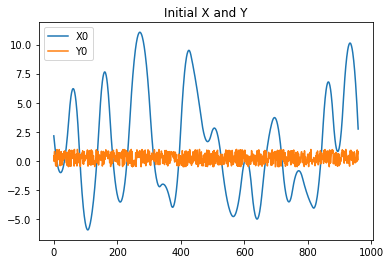

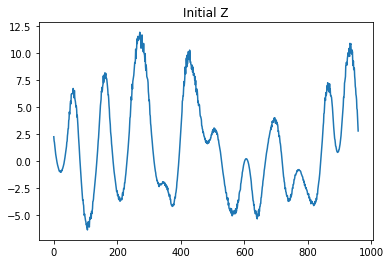

In [9]:
plt.figure()
plt.plot(X0)
plt.plot(Y0)
plt.legend(['X0', 'Y0'])
plt.title('Initial X and Y')

plt.figure()
plt.plot(Z0)
plt.title('Initial Z')

In [10]:
t = np.linspace(0, 20, 100)

In [11]:
Z = return_LM3_data(Z0, t, K=K, I=I, F=F, b=b, c=c)

In [12]:
theta_Z = np.linspace(0, 2 * np.pi, N_Z + 1)

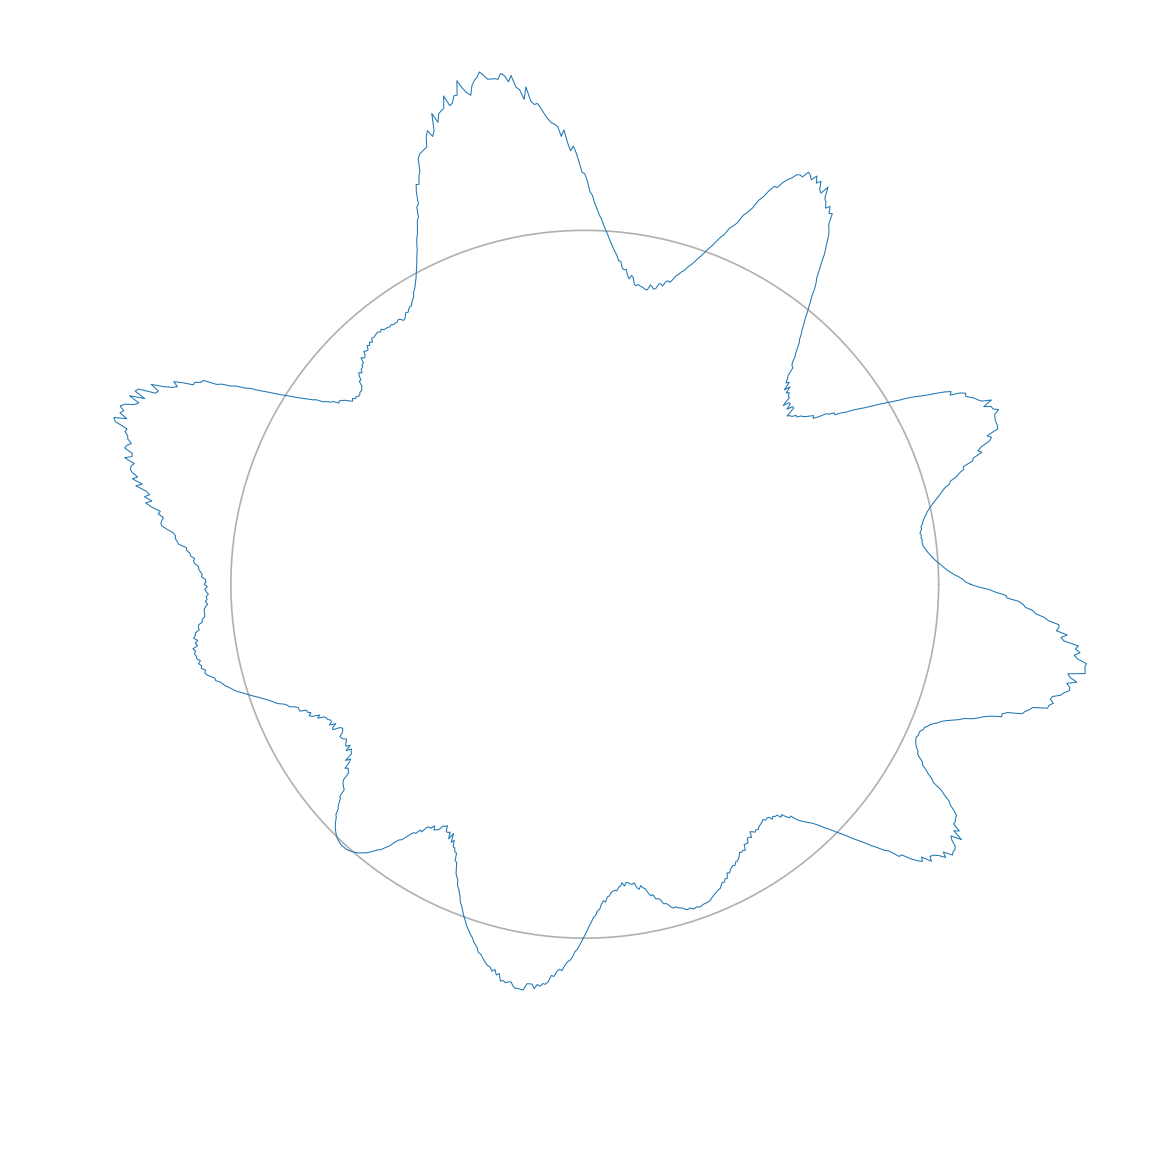

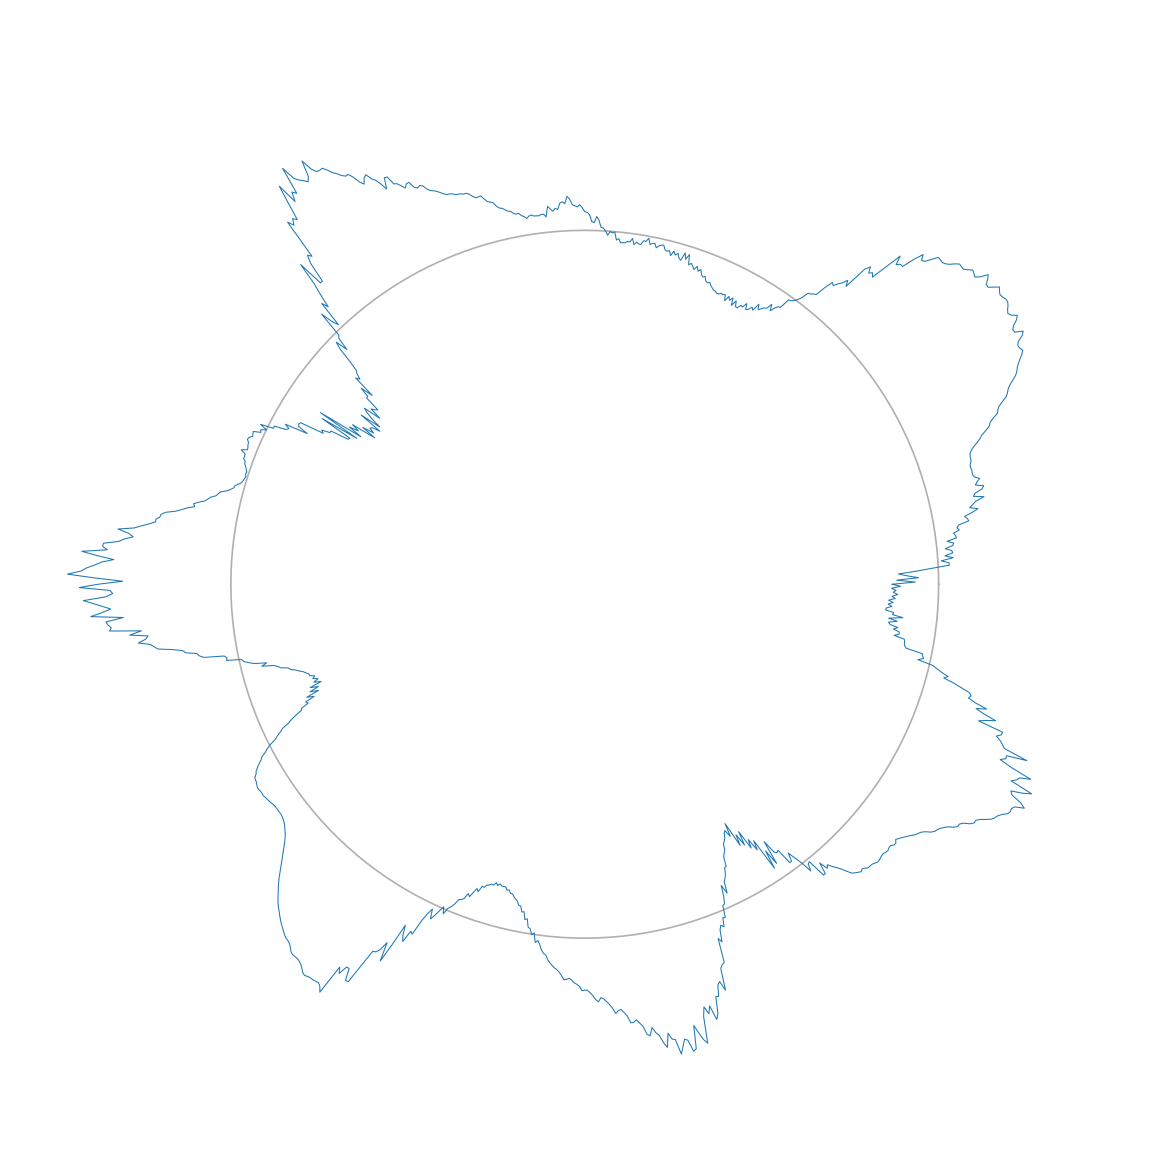

In [13]:
for ii in [0, -1]:
    Z_to_plot = Z[:, ii]
    Z_to_plot = np.concatenate([Z_to_plot, 
                                [Z_to_plot[0]]])
    
    plt.figure(figsize=(10,10), dpi=150)
    axes = plt.subplot(111, polar=True)
    plt.polar(theta_Z, Z_to_plot, linewidth=0.5)
    plt.yticks([0])
    plt.ylim([-25, 15])
    axes.set_yticklabels([])
    plt.xticks([])
    axes.spines['polar'].set_visible(False)

# Use end of run as init

In [14]:
Z0 = Z[:, -1]

In [15]:
T = 1000
dt = 0.05
N = int(T/dt + 1)
t = np.linspace(0, T, N)

# Long run to generate ensemble

In [18]:
# Z = return_LM3_data(Z0, t, K=K, I=I, F=F, b=b, c=c)

# np.save('./Z_long_run.npy', Z)

Z = np.load('./RK_tune/Z_long_run.npy')

In [19]:
X = window_sum_Z(Z, I=I, alpha=alpha, beta=beta)
Y = Z - X

In [30]:
Z_std = np.std(Z)
X_std = np.std(X)
Y_std = np.std(Y)

print(f'Z std: {Z_std:0.4}')
print(f'X std: {X_std:0.4}')
print(f'Y std: {Y_std:0.4}')

print(f'X std is {(X_std/Y_std):0.4} times larger than Y std')

Z std: 4.678
X std: 4.668
Y std: 0.1724
X std is 27.08 times larger than Y std


In [31]:
np.sqrt(2) * Z_std

6.616180421248237

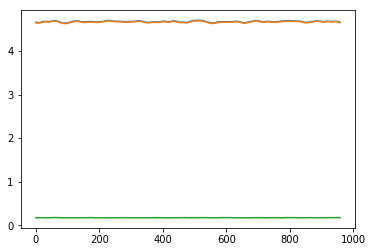

In [25]:
plt.figure()
plt.plot(Z_std)
plt.plot(X_std)
plt.plot(Y_std)

In [23]:
Z_std.shape

(960,)

In [21]:
Z.shape

(960, 40001)

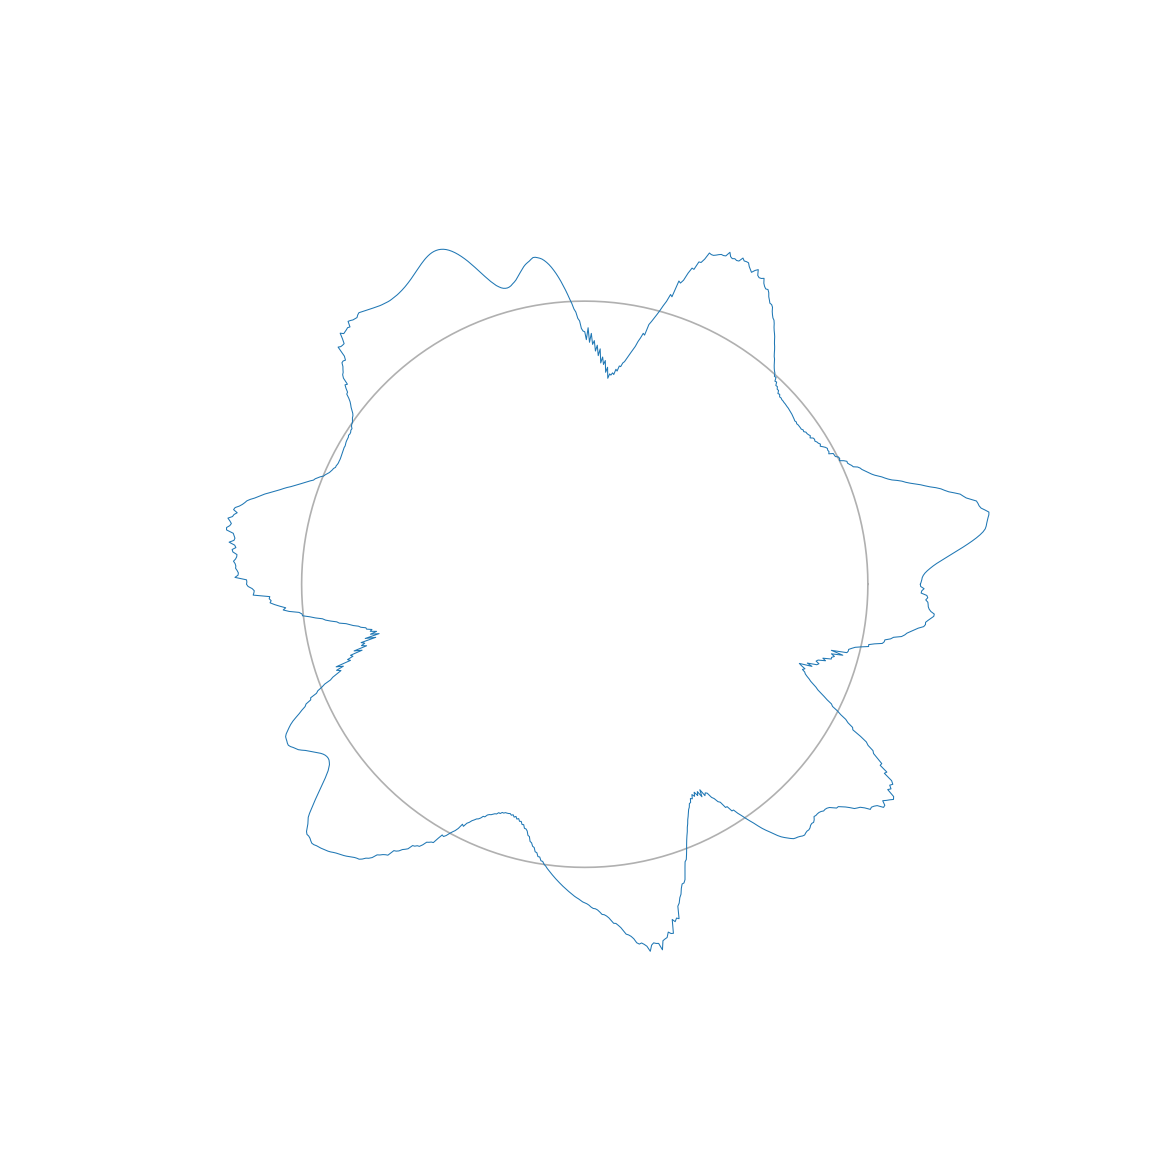

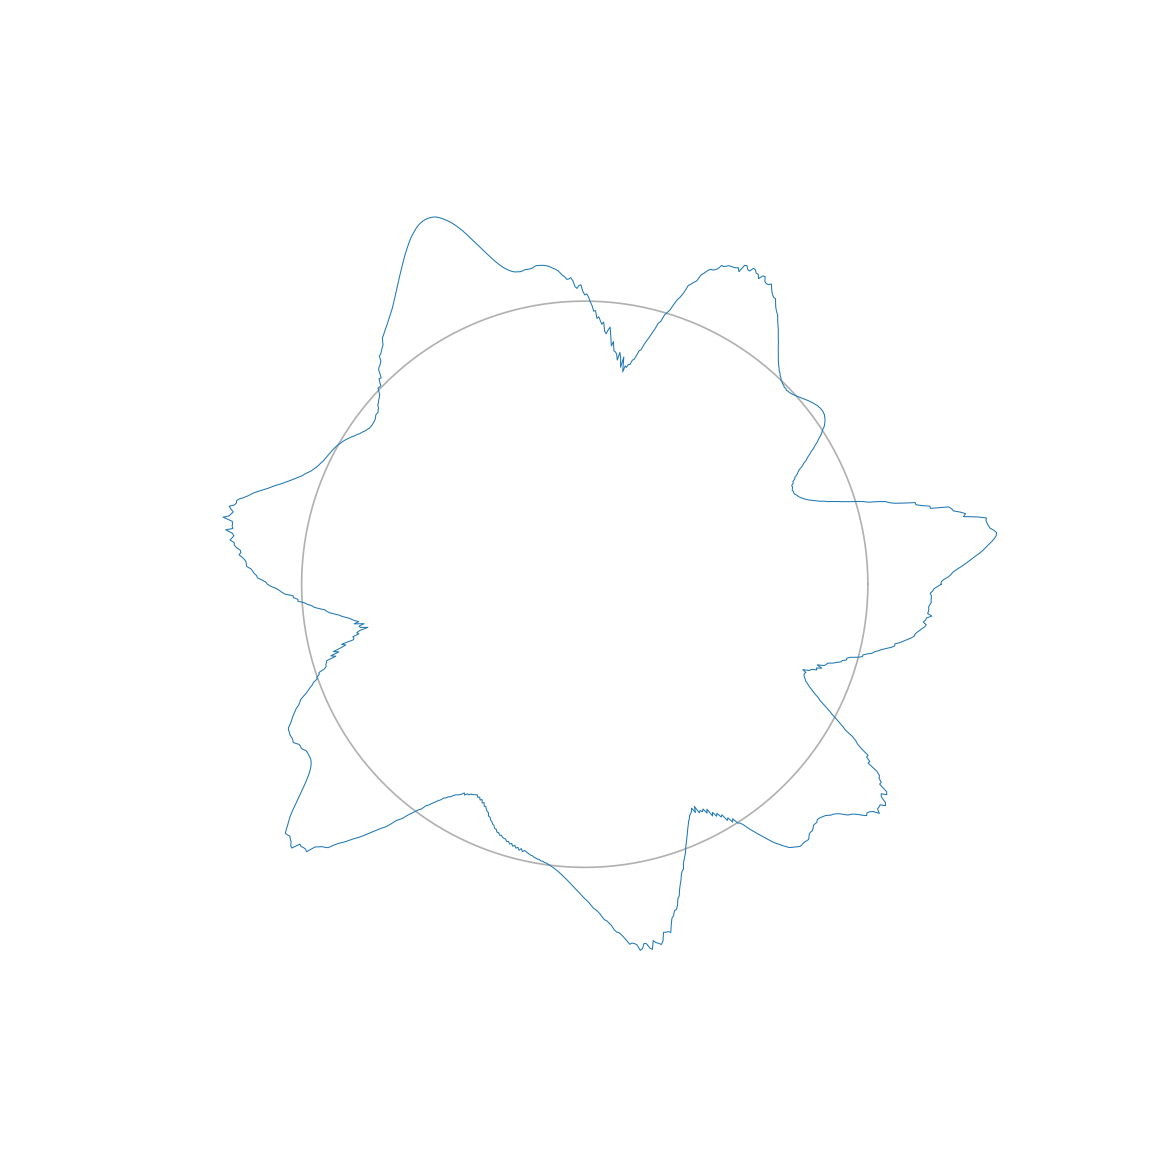

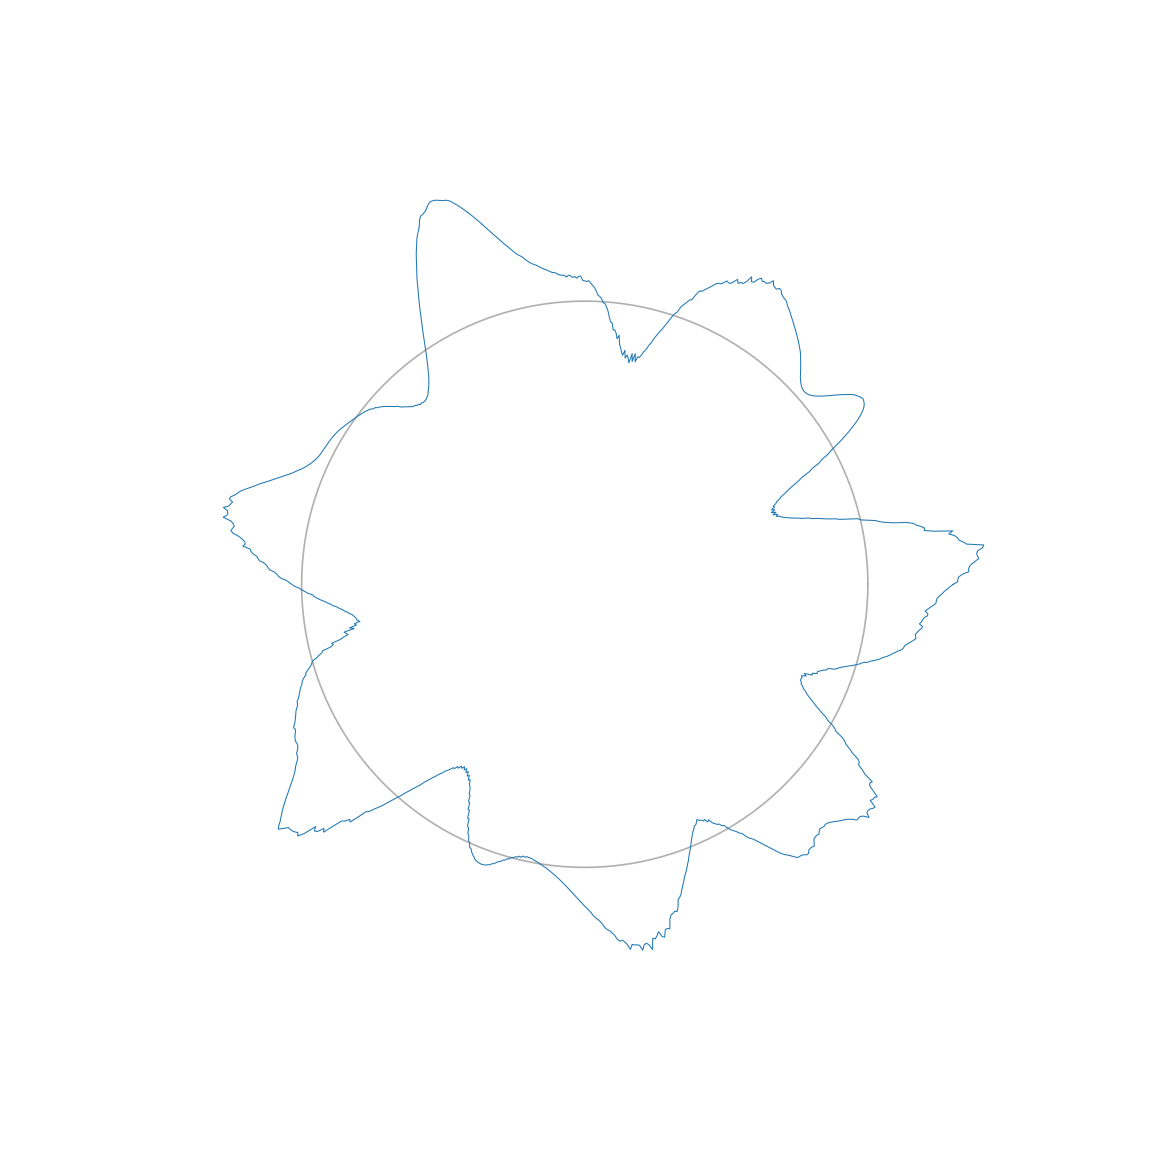

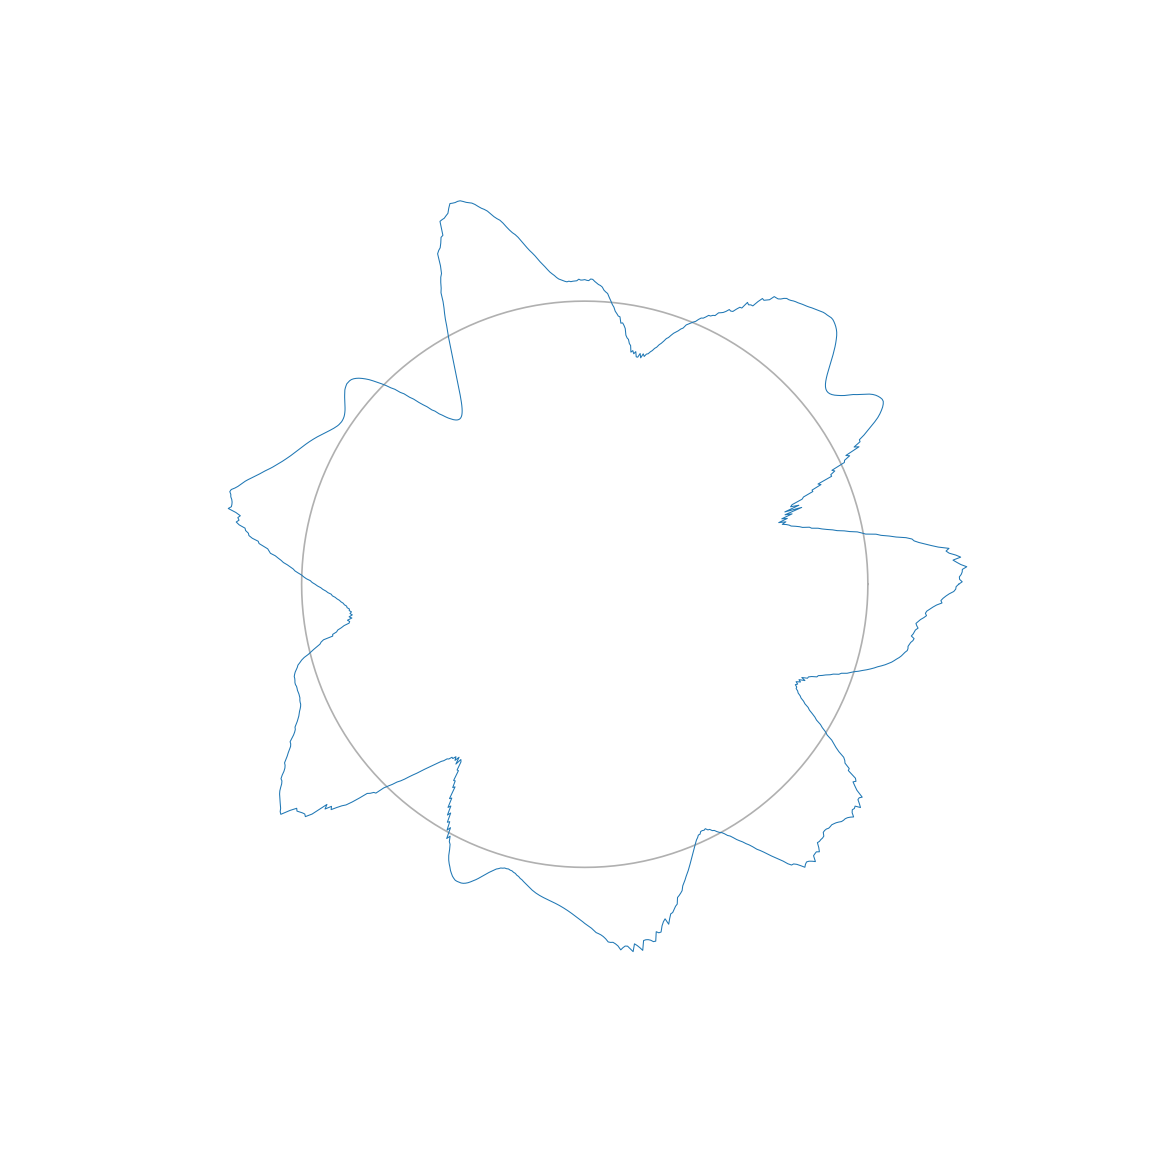

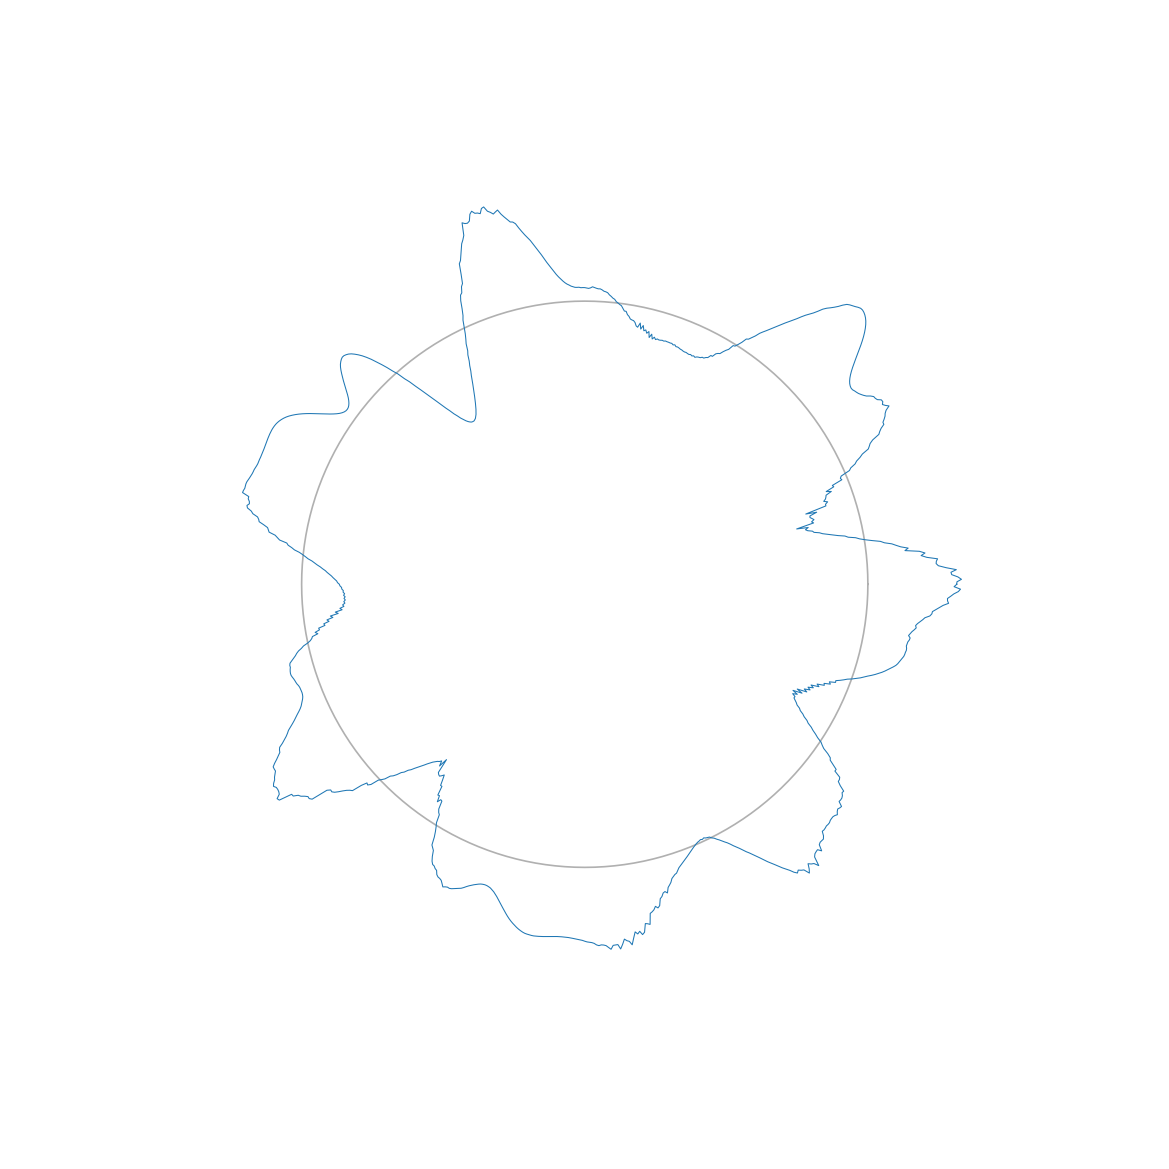

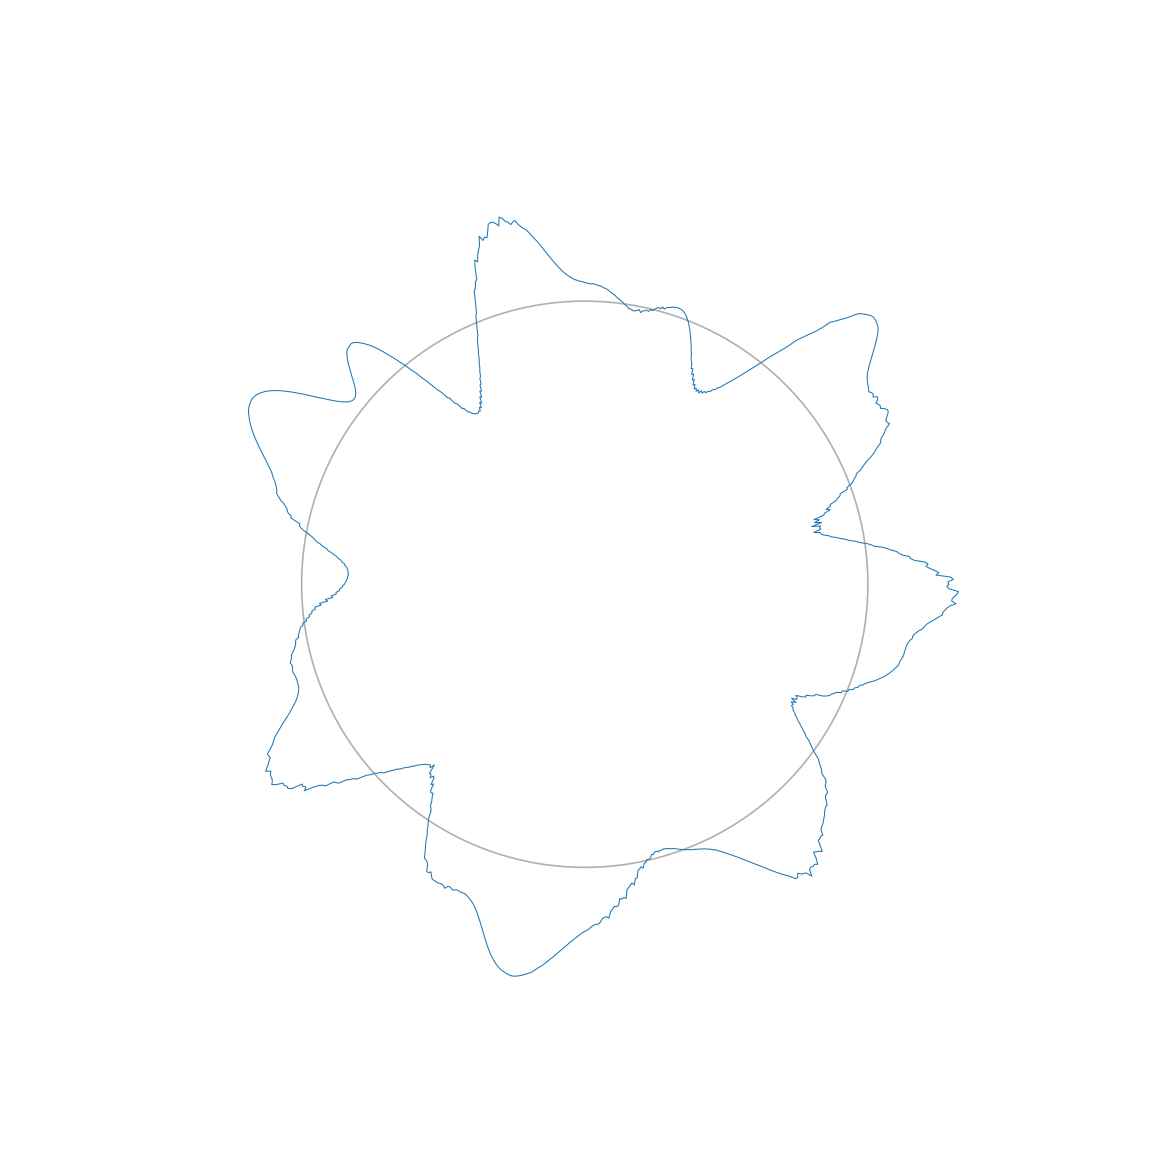

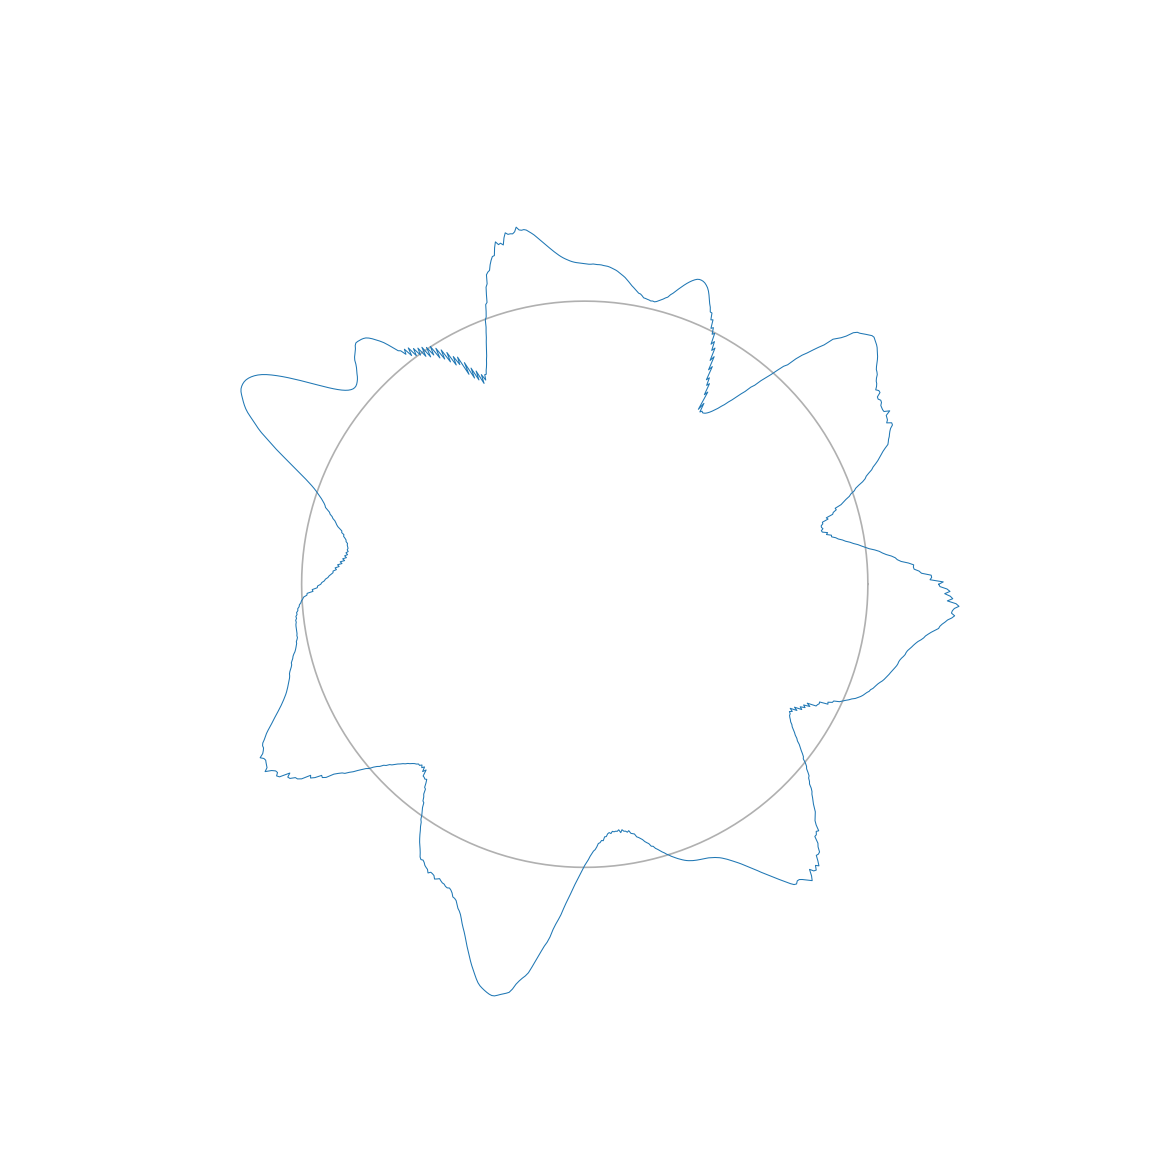

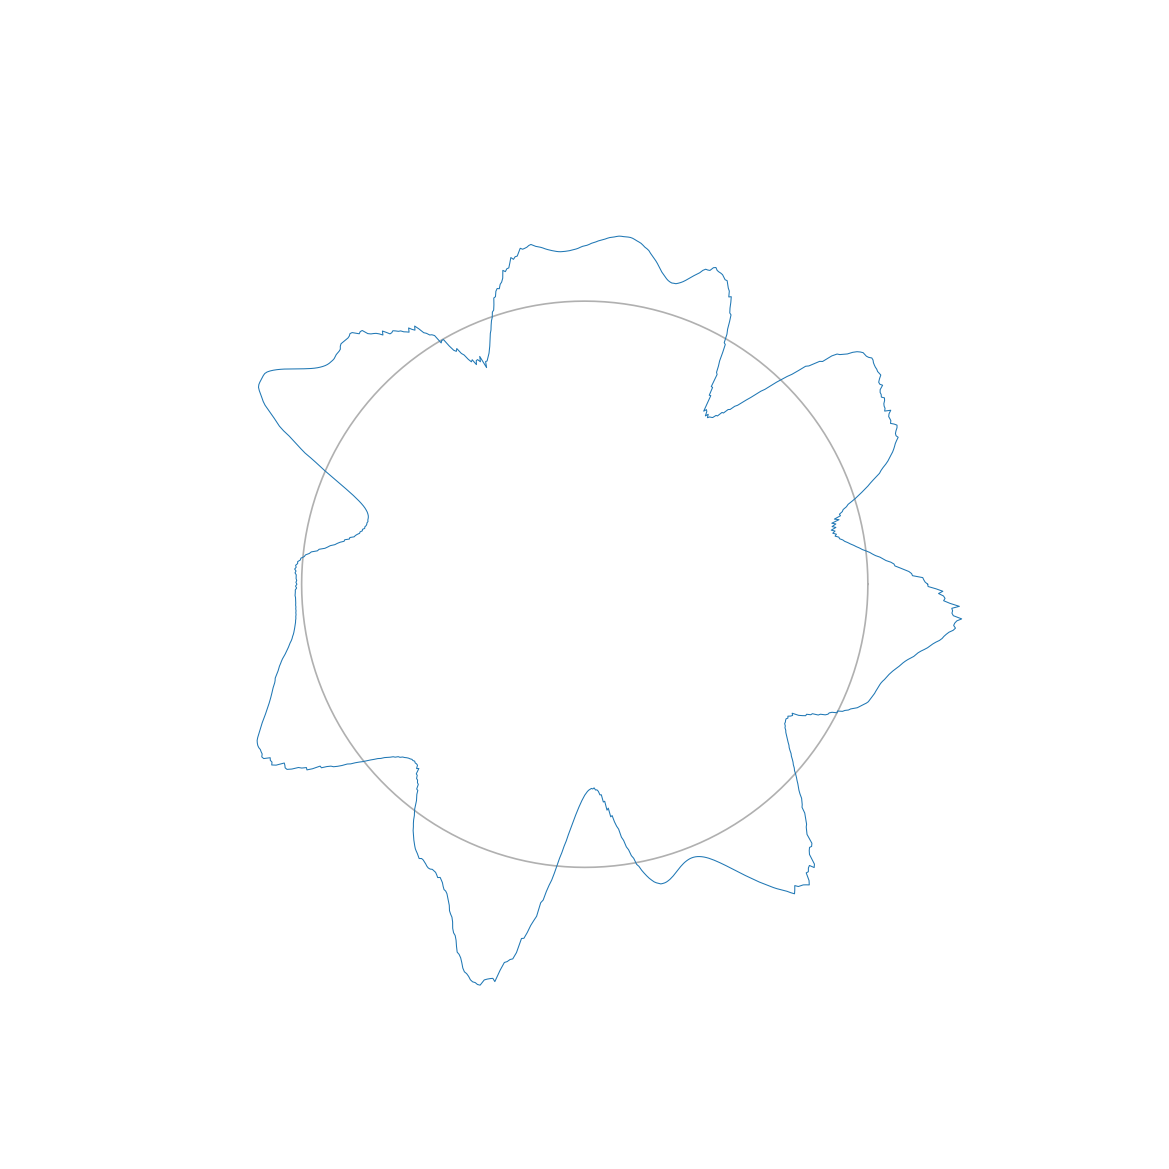

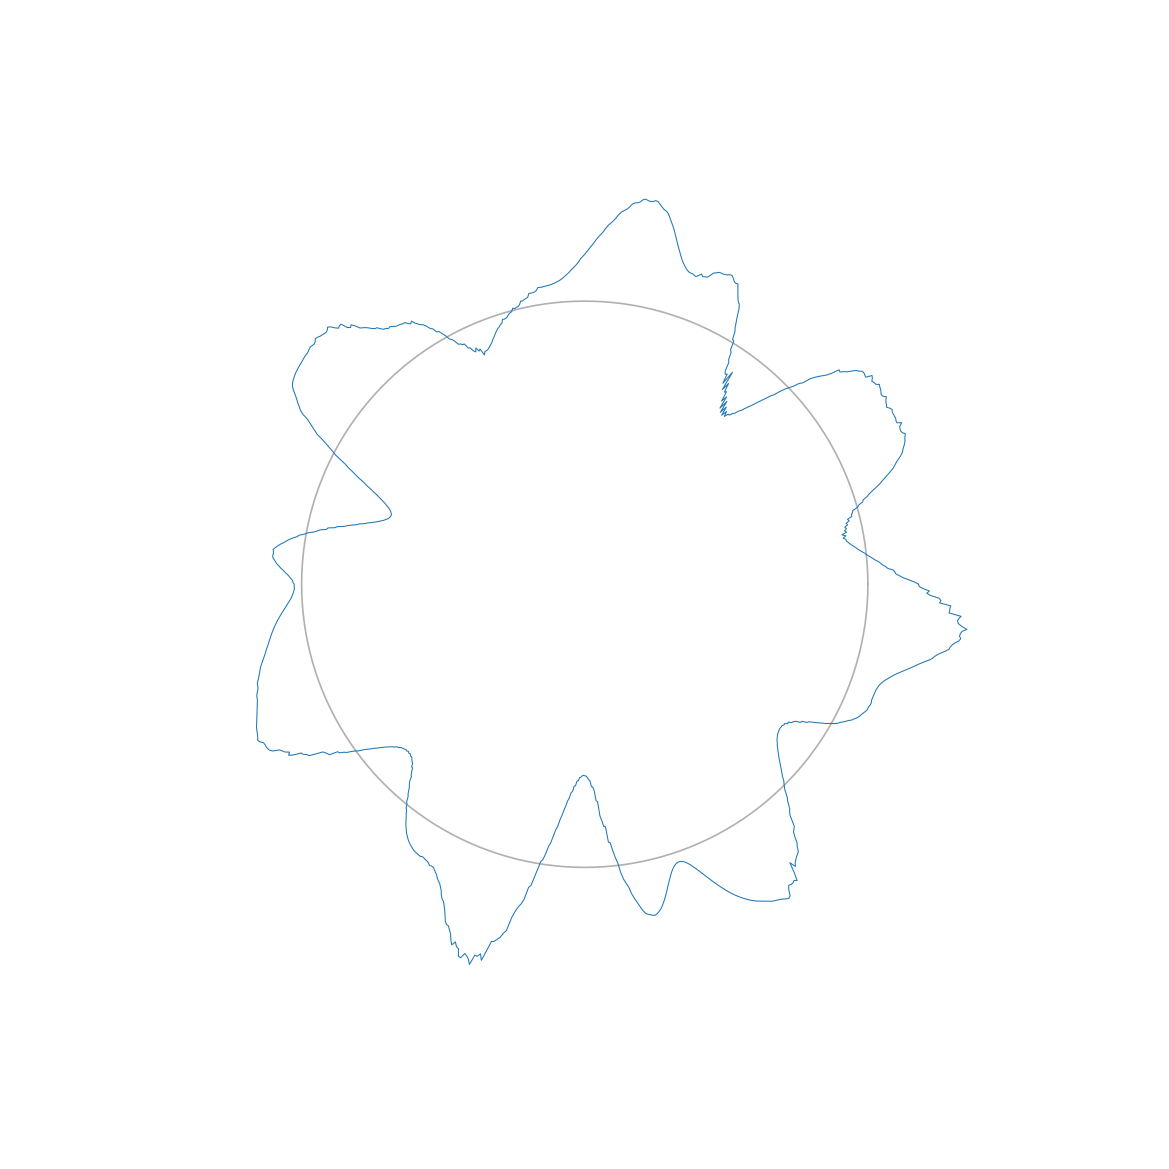

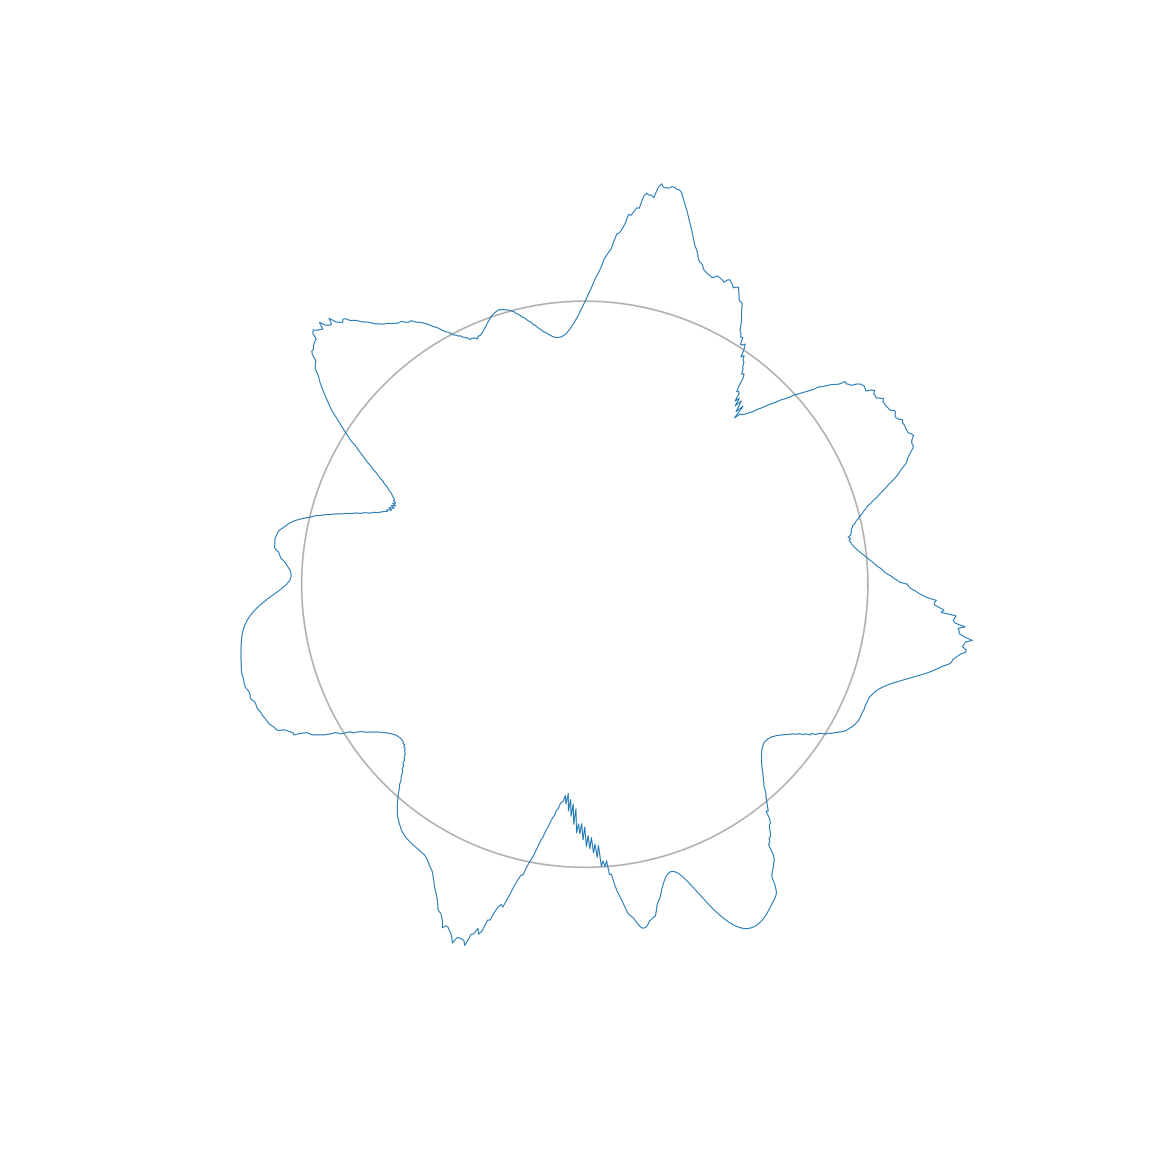

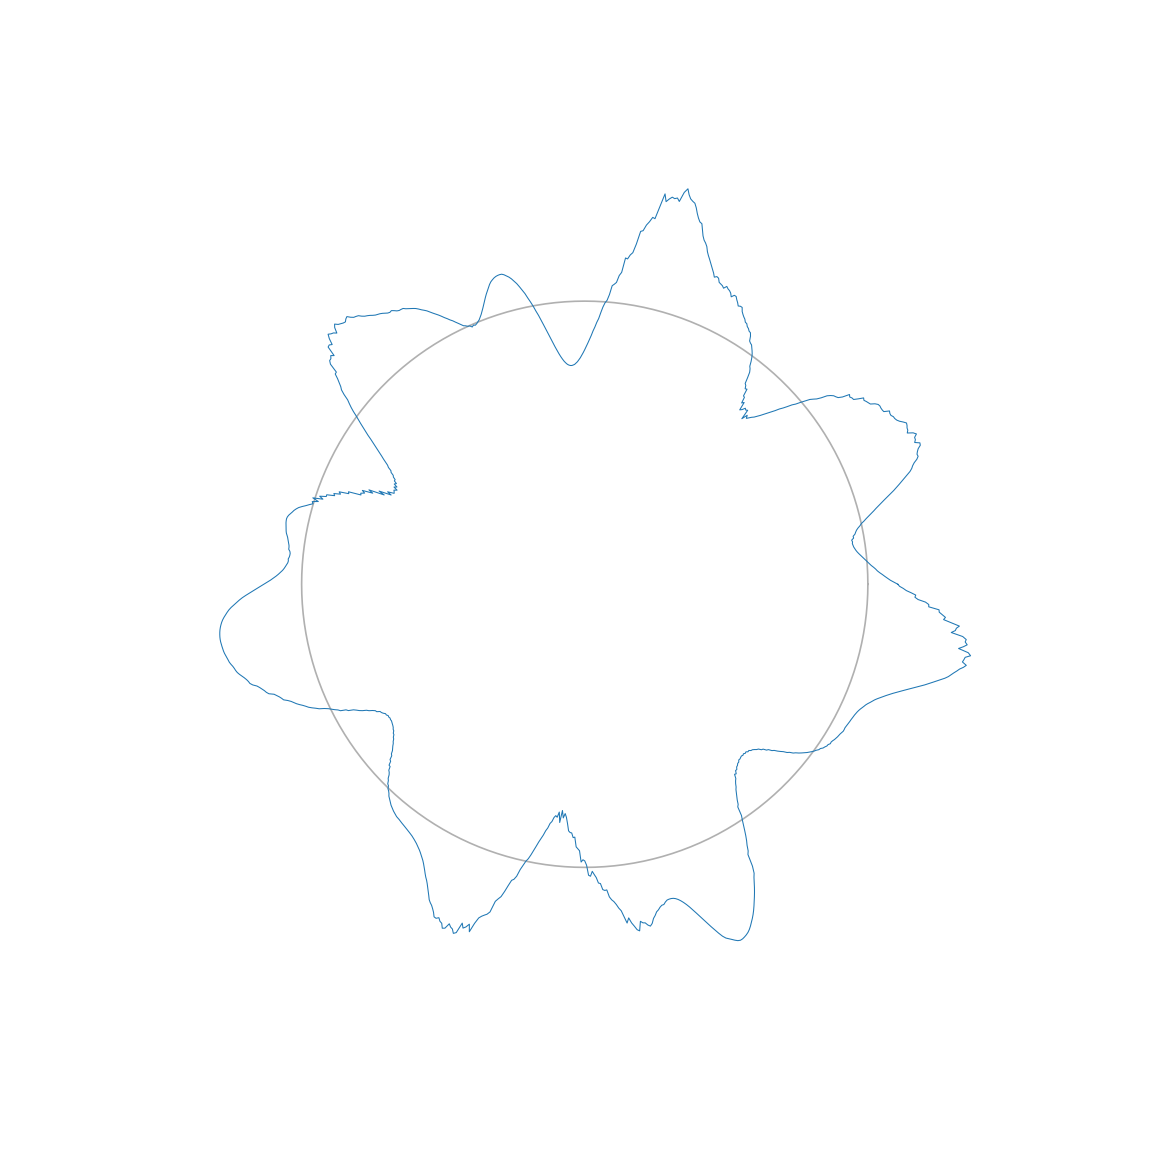

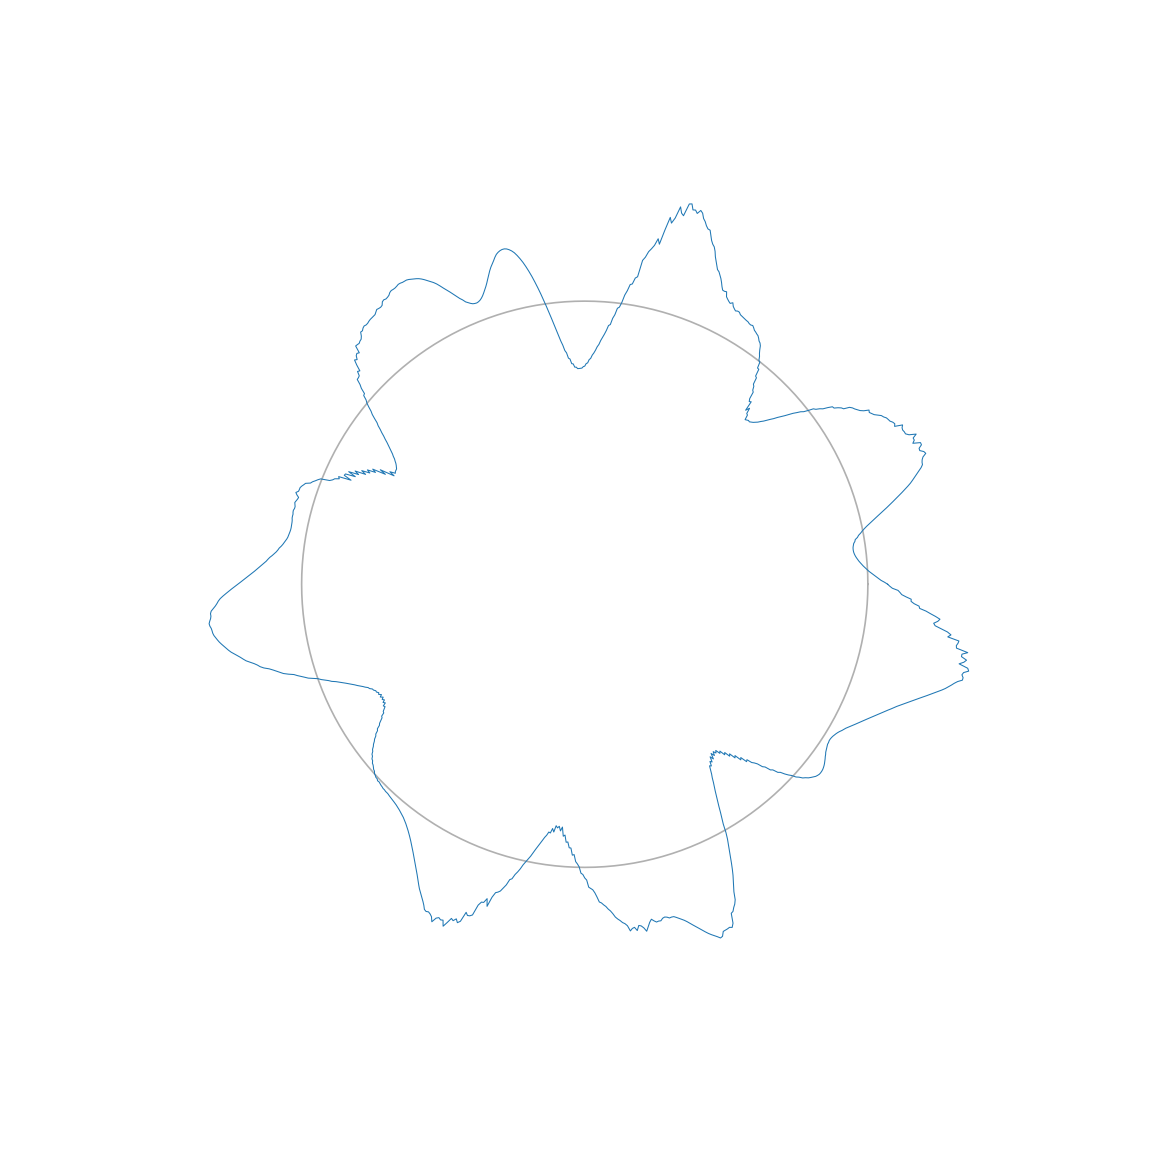

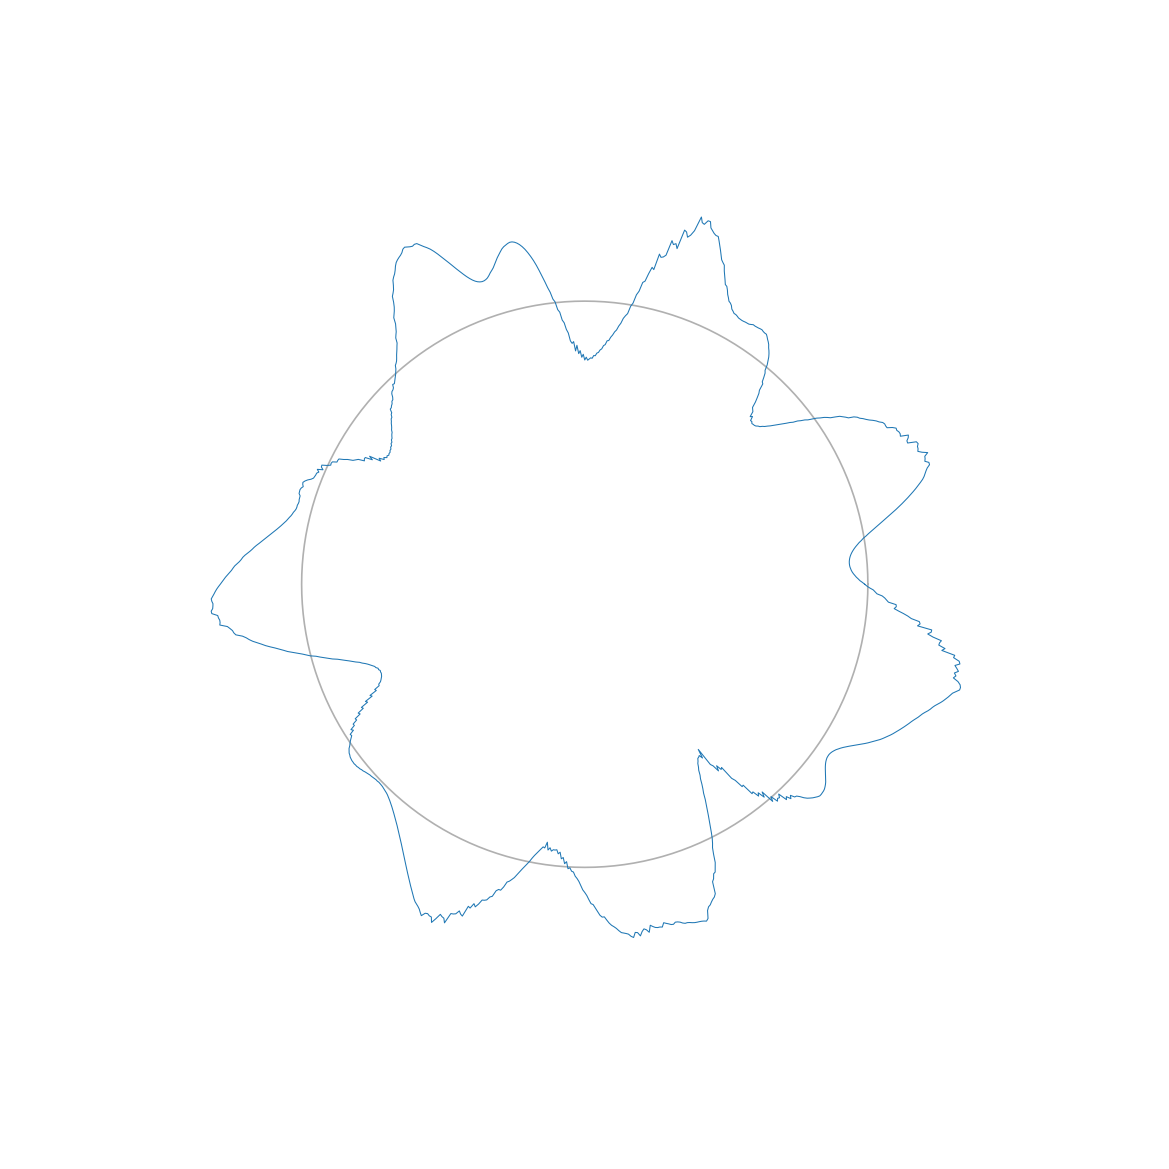

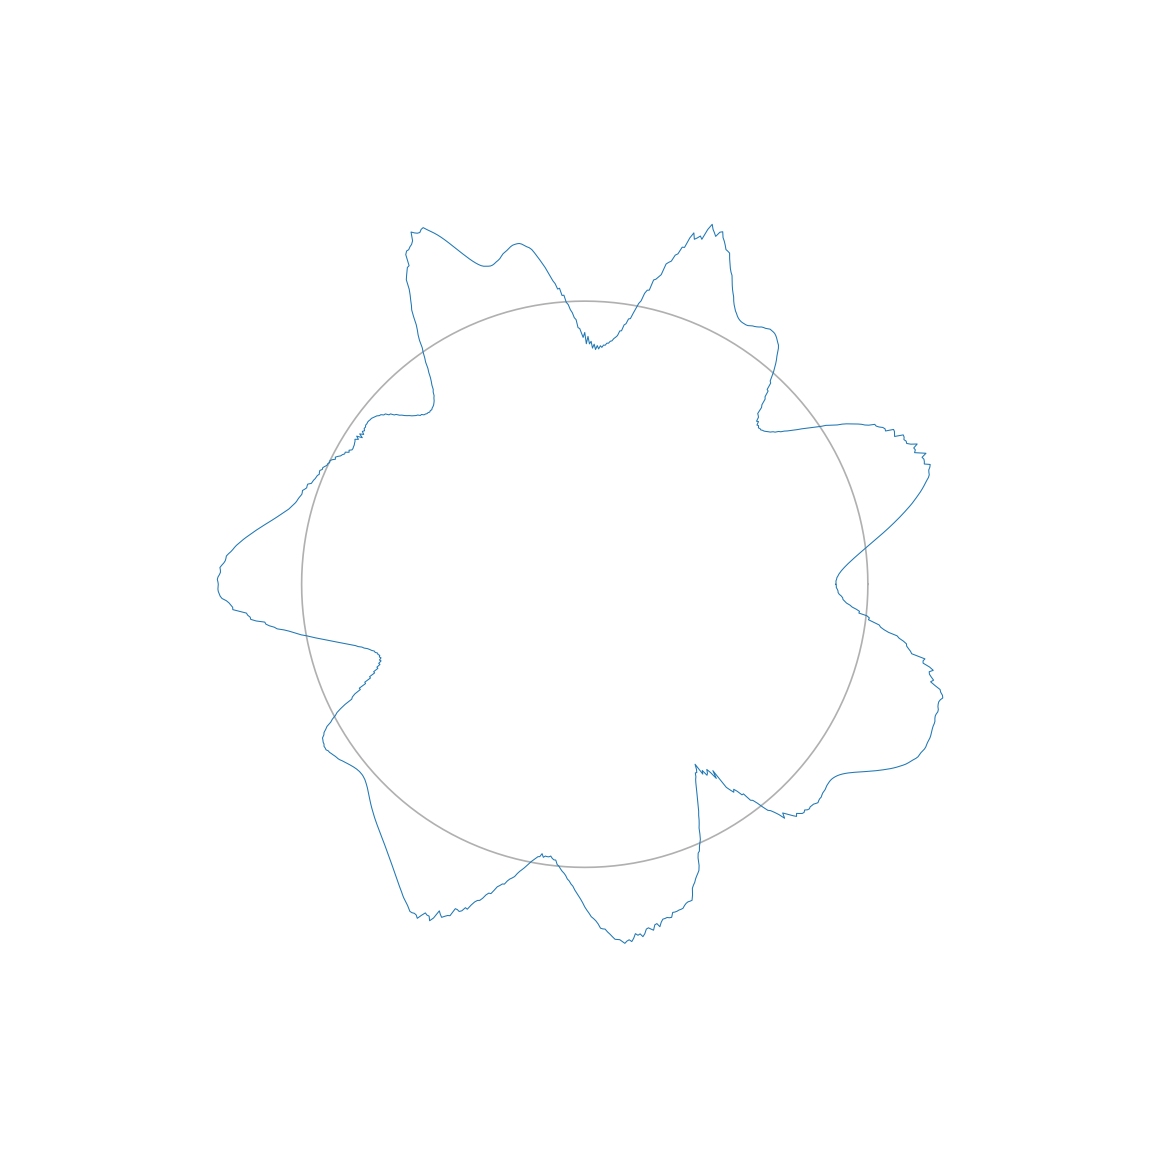

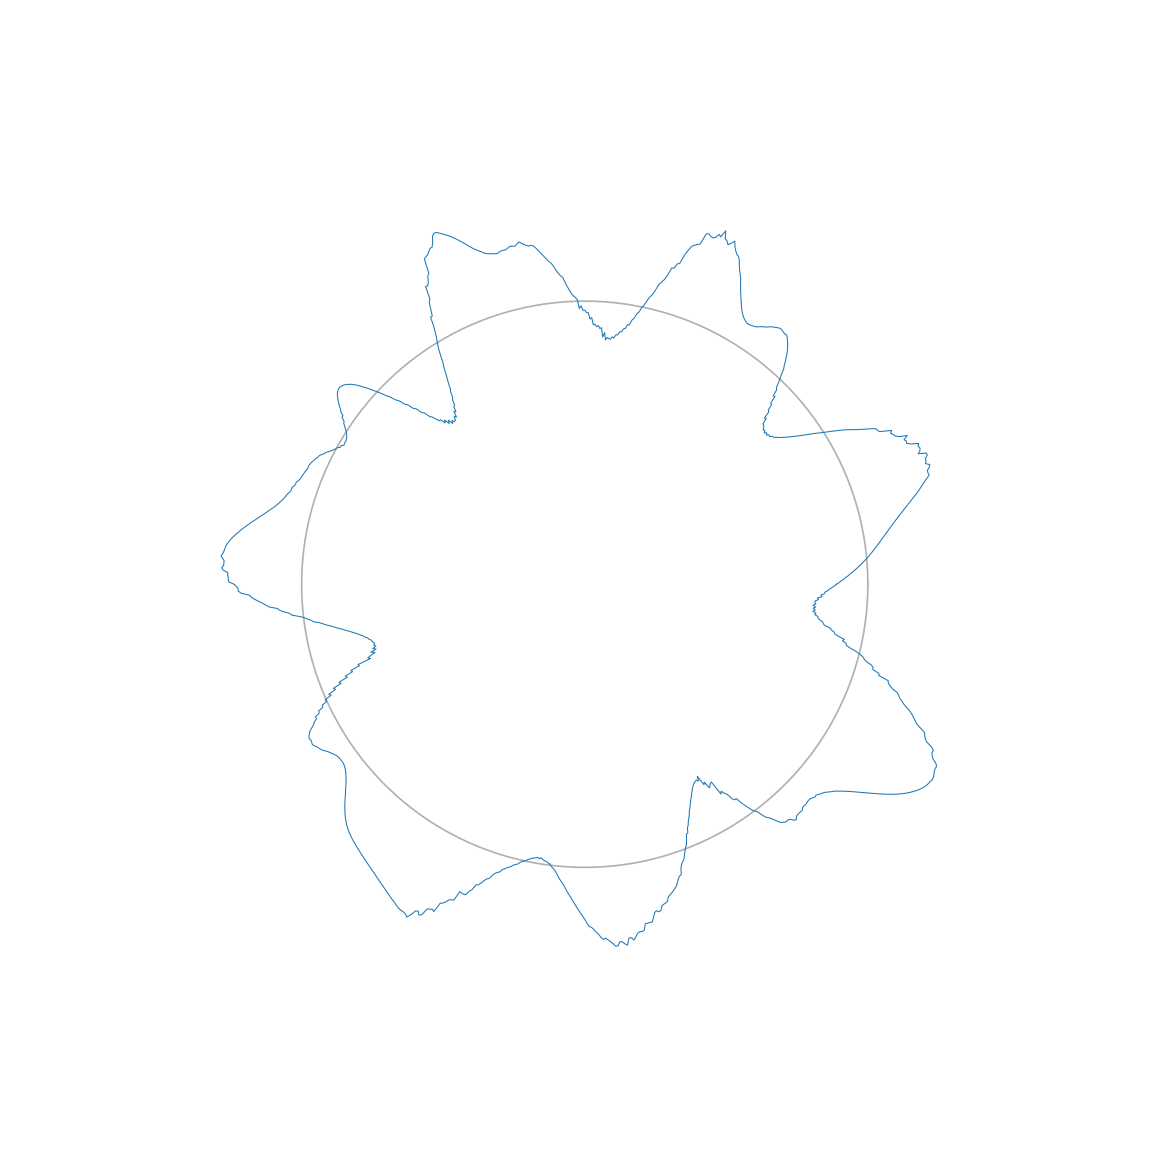

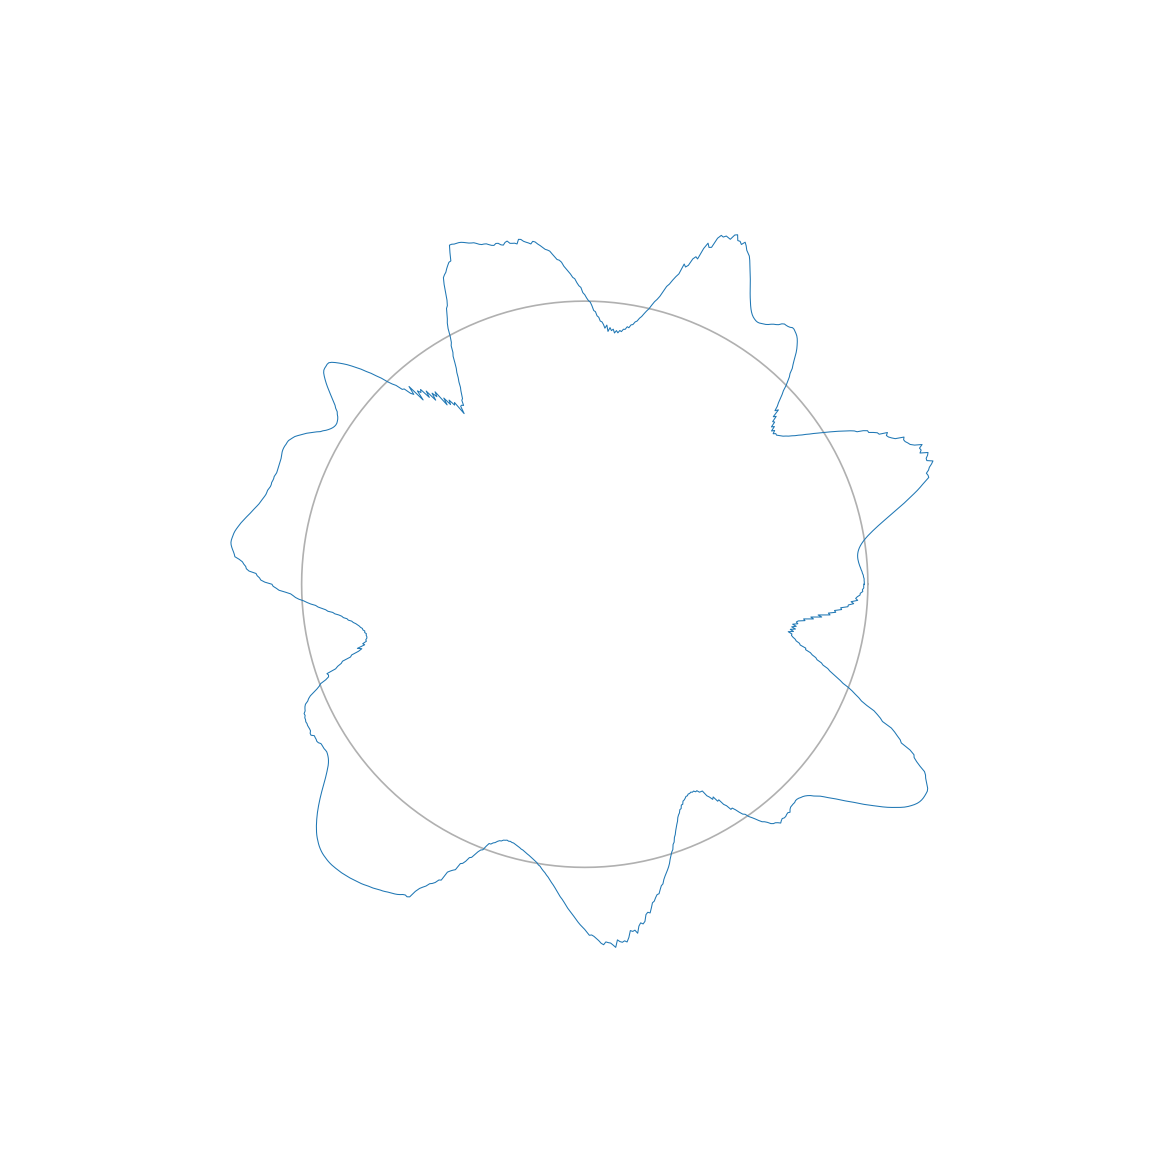

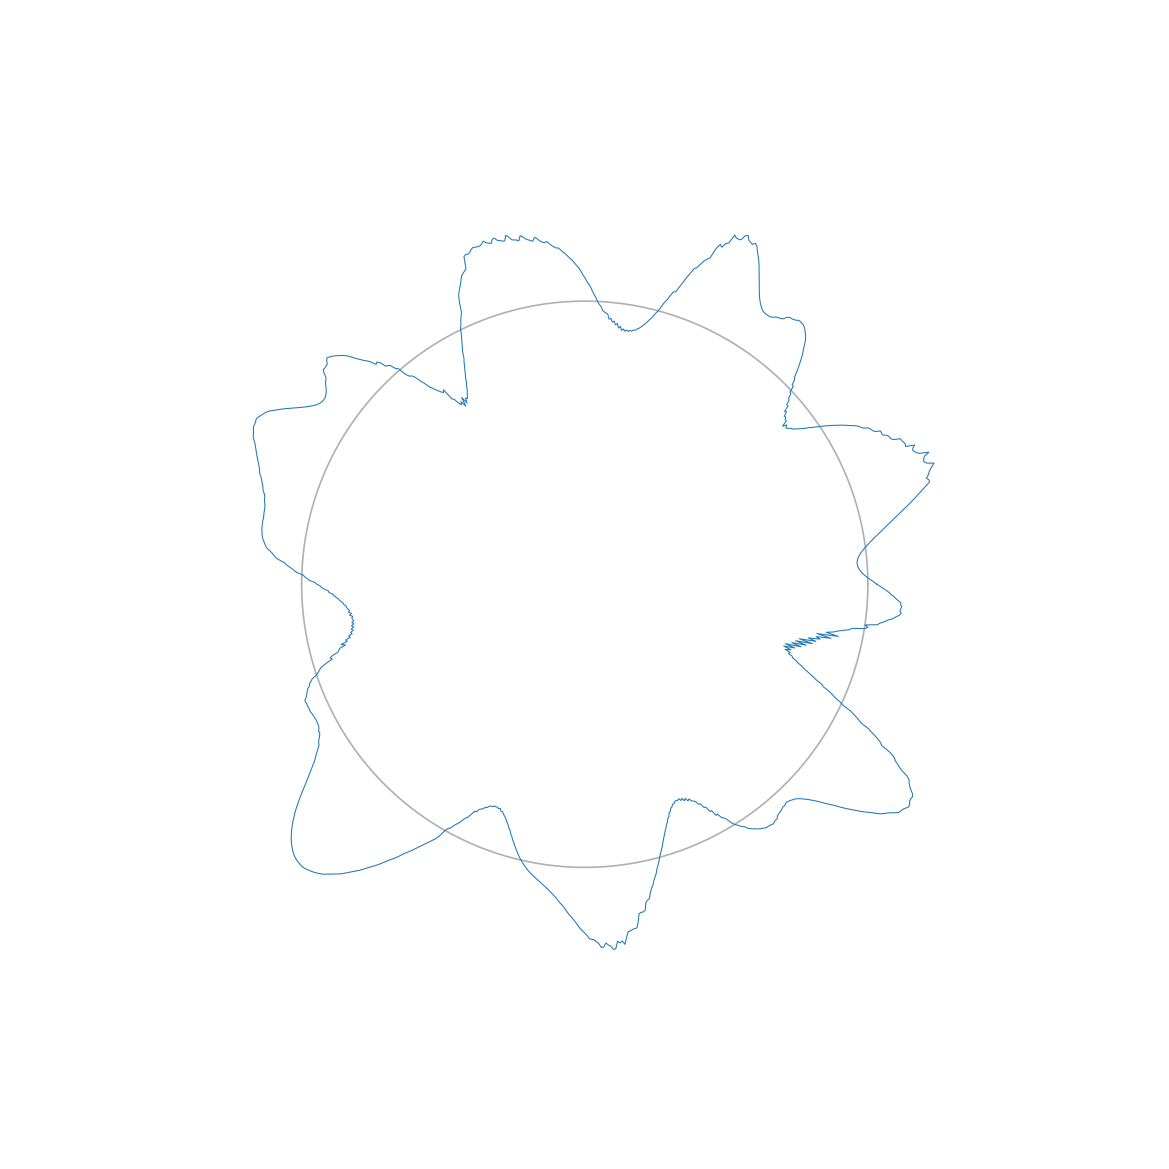

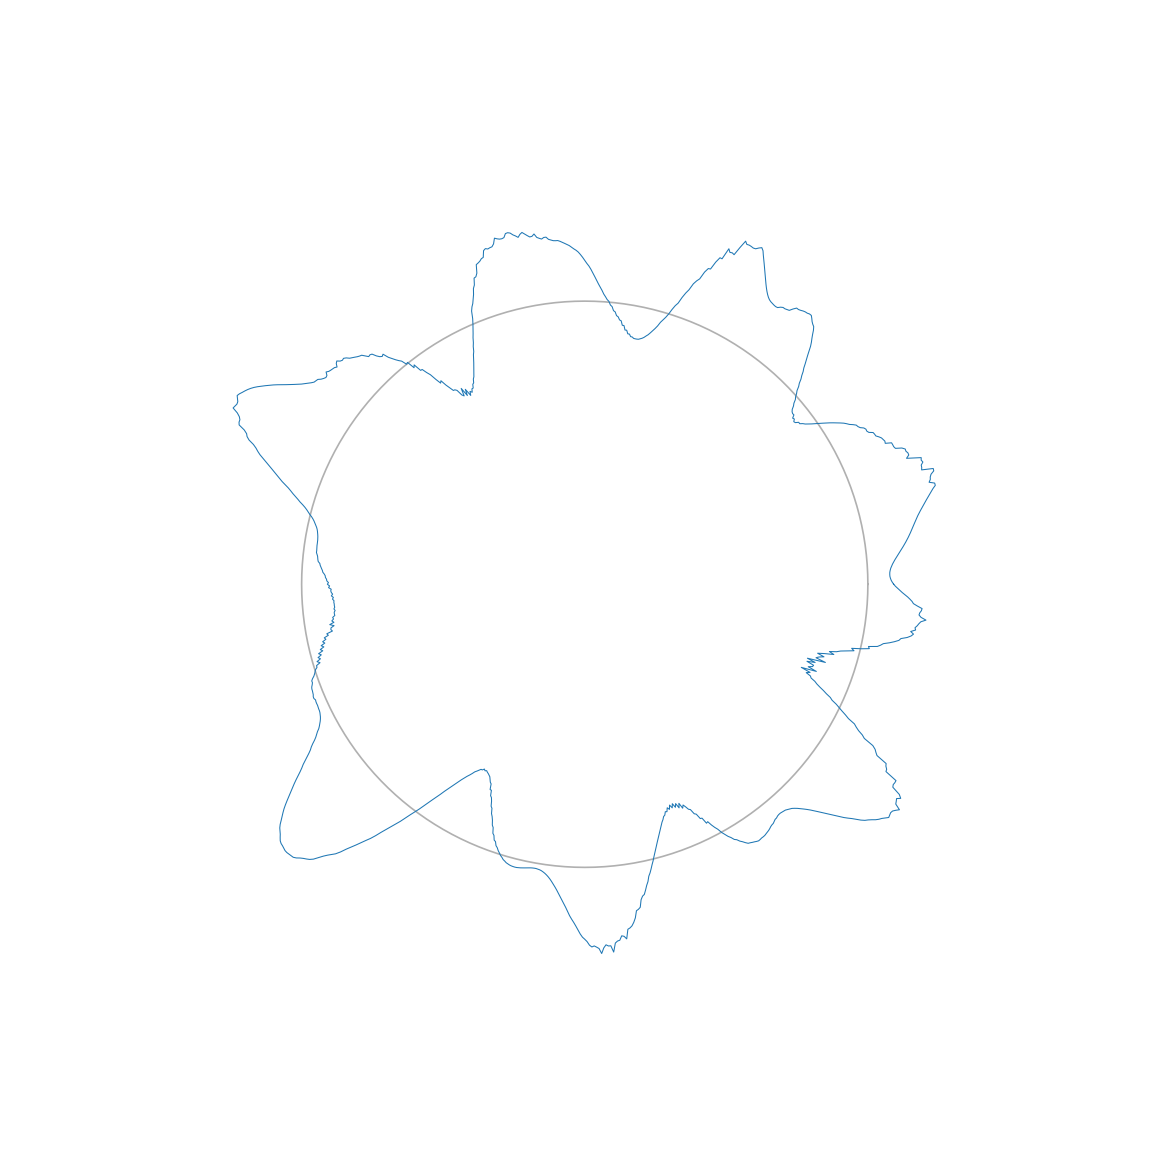

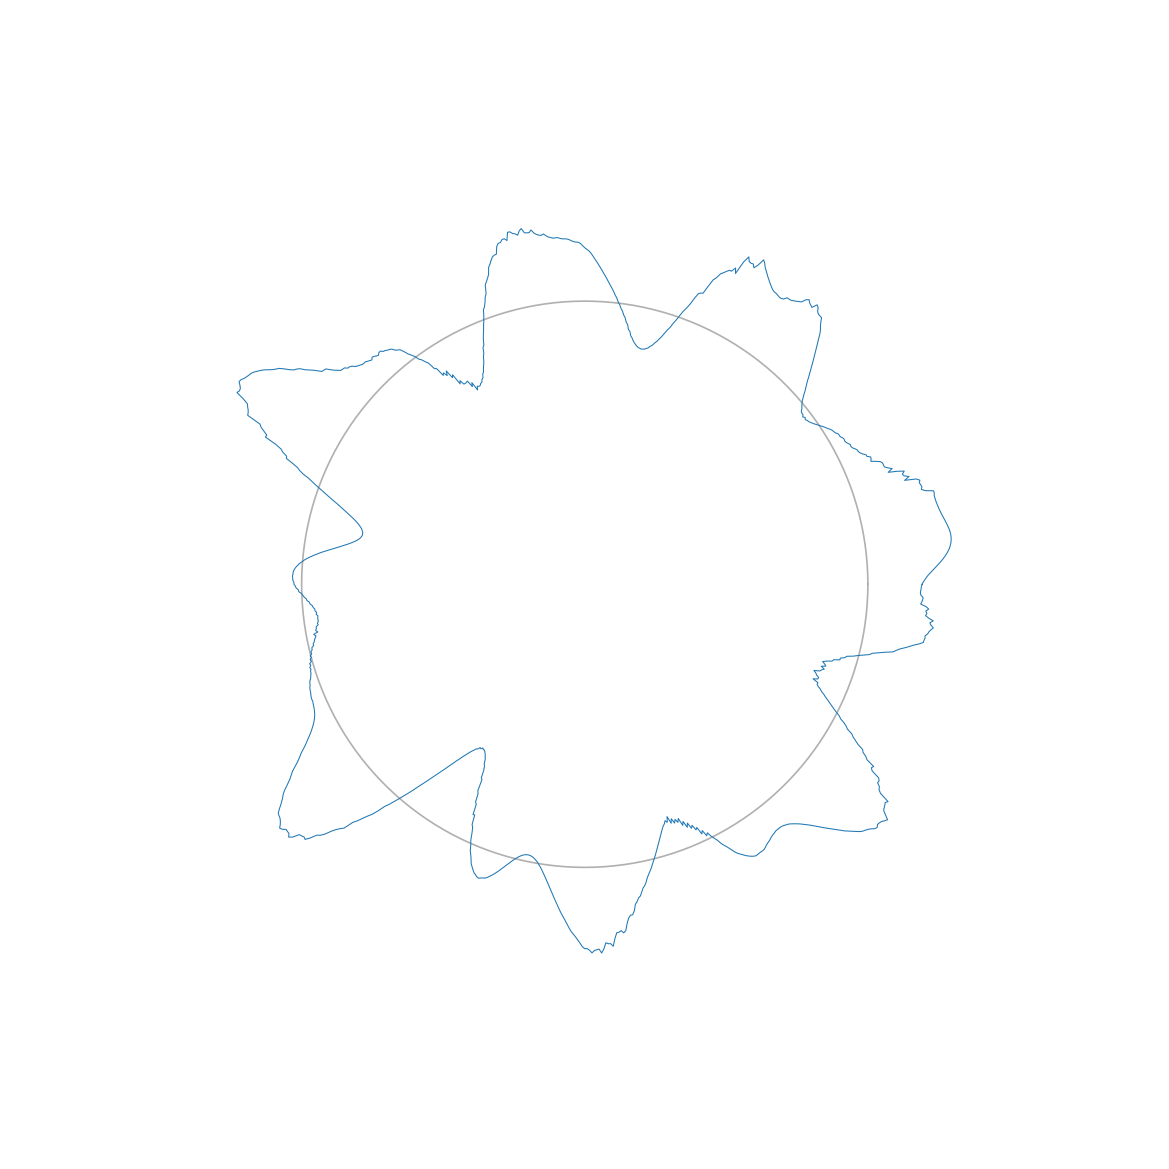

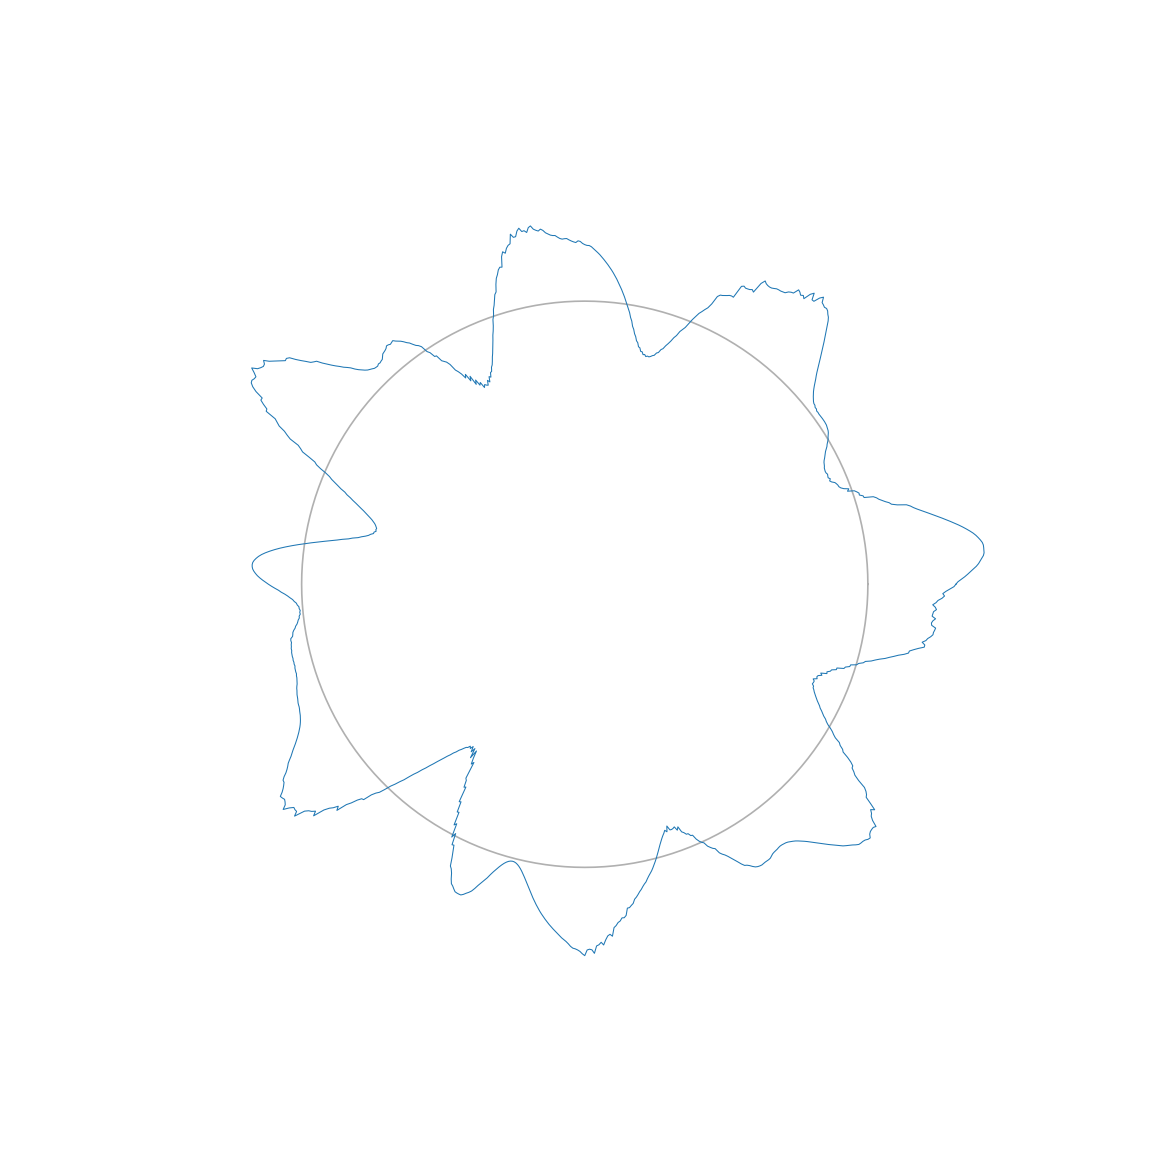

In [20]:
# On a ring
for ii in range(20): #range(XY.shape[0]):
#     ii = 5 * ii
    Z_to_plot = Z[:, ii]
    Z_to_plot = np.concatenate([Z_to_plot, 
                                [Z_to_plot[0]]])
    
    plt.figure(figsize=(10,10), dpi=150)
    axes = plt.subplot(111, polar=True)
    plt.polar(theta_Z, Z_to_plot, linewidth=0.5)
    plt.yticks([0])
    plt.ylim([-30, 30])
    axes.set_yticklabels([])
    plt.xticks([])
    axes.spines['polar'].set_visible(False)

In [ ]:
# on a line
for ii in range(20): #range(XY.shape[0]):
#     ii = 5 * ii
    Z_to_plot = Z[:, ii]
    X_to_plot = X[:, ii]
    X_coarse_to_plot = X_to_plot[::8]
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(Z_to_plot)
    plt.plot(X_to_plot)
    plt.plot(x[::8], X_coarse_to_plot)
    plt.title(f'Z and X at time {ii*dt}')
    plt.legend(['Z', 'X', 'X_coarse'])

In [ ]:
# X, Y, and Z separated out
ymax = Z.max()
ymin = Z.min()
for ii in range(20): #range(XY.shape[0]):
#     ii = 5 * ii
    Z_to_plot = Z[:, ii]
    X_to_plot = X[:, ii]
    Y_to_plot = Y[:, ii]
    figsize = plt.figaspect(1/8) * 2
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(Z_to_plot)
    plt.plot(X_to_plot)
    plt.plot(Y_to_plot)
    plt.ylim([ymin, ymax])
    plt.xlim([0, Z_to_plot.size])
    plt.title(f'Z, X, and Y at time {ii*dt}')

In [ ]:
def generate_Z_ens(Z_ts, N_eZ):
    N_t = Z_ts.shape[1]
    fine_indices = np.random.choice(N_t, size=N_eZ, replace=False)
    Z_ens = Z_ts[:, fine_indices]
    return Z_ens

In [ ]:
def generate_X_ens(Z_ts, *, I, alpha, beta, N_eX, coarse):
    X_ens = generate_Z_ens(Z_ts, N_eX)
    X_ens = window_sum_Z(X_ens, I=I, alpha=alpha, beta=beta)
    X_ens = X_ens[::coarse]
    return X_ens

In [ ]:
Z0_ens = generate_Z_ens(Z, N_eZ)

np.save('Z0_ens', Z0_ens)
# Z0_ens = np.load('Z0_ens.npy')

In [ ]:
X0_ens = generate_X_ens(Z, I=I, alpha=alpha, beta=beta, N_eX=N_eX, coarse=coarse)

np.save('X0_ens', X0_ens)
# X0_ens = np.load('X0_ens.npy')

In [ ]:
for ii in range(5): # range(Z0_ens.shape[1]): # 
    Z_to_plot = Z0_ens[:, ii]
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(Z_to_plot)
    plt.title(f'Z sample')

In [ ]:
for ii in range(5): #range(XY.shape[0]):
    X_to_plot = X0_ens[:, ii]
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(x[::coarse], X_to_plot)
    plt.title(f'X sample')

In [ ]:
Z_ens_mean = Z0_ens.mean(axis=1)
Z_ens_sd = np.std(Z0_ens, axis=1)
X_ens_mean = X0_ens.mean(axis=1)
X_ens_sd = np.std(X0_ens, axis=1)

In [ ]:
X_to_plot = X_ens_mean
Z_to_plot = Z_ens_mean
figsize = plt.figaspect(1/4)
plt.figure(dpi=150, figsize=figsize)
plt.plot(Z_to_plot)
plt.plot(x[::coarse], X_to_plot)
plt.title(f'Sample means')
plt.legend(['Z', 'X'])

In [ ]:
X_to_plot = X_ens_sd
Z_to_plot = Z_ens_sd
figsize = plt.figaspect(1/4)
plt.figure(dpi=150, figsize=figsize)
plt.plot(Z_to_plot)
plt.plot(x[::coarse], X_to_plot)
plt.title(f'Sample point std')
plt.legend(['Z', 'X'])

In [ ]:
plt.figure()
im = plt.imshow(P_X)
plt.colorbar(im)
plt.title('Covariance X from big ens')

plt.figure()
im = plt.imshow(P_Z)
plt.colorbar(im)
plt.title('Covariacne Z from small ens')


plt.figure()
im = plt.imshow(C_X)
plt.colorbar(im)
plt.title('Correlation X from big ens')

plt.figure()
im = plt.imshow(C_Z)
plt.colorbar(im)
plt.title('Correlation Z from small ens')\

# Pushing Z ensemble forwad in time

In [ ]:
def return_LM3_ens_data(Z0_ens, t, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    N_Z, N_eZ = Z0_ens.shape
    N_t = t.size
    def this_LM3(Z_1d_ens, t):
        Z_ens = Z_1d_ens.reshape(N_Z, N_eZ)
        dZdt = LM3(Z_ens, K=K, I=I, F=F, b=b, c=c, alpha=alpha, beta=beta)
        return dZdt.ravel()
    Z_ens_1d = integrate.odeint(this_LM3, Z0_ens.ravel(), t)
    Z_ens_1d = Z_ens_1d.T
    Z_ens_ts = Z_ens_1d.reshape(N_Z, N_eZ, N_t)
    return Z_ens_ts

In [ ]:
T = 1
dt = 0.05
N_t = int(T/dt + 1)
t = np.linspace(0, T, N_t)

In [ ]:
Z_ens_ts = return_LM3_ens_data(Z0_ens, t, K=K, I=I, F=F, b=b, c=c)

In [ ]:
kk = 0
ymax=Z_ens_ts[:, kk, :].max()
ymin=Z_ens_ts[:, kk, :].min()
for ii in range(5): # range(Z0_ens.shape[1]): # 
#     ii = 5 * ii
    Z_to_plot = Z_ens_ts[:, kk, ii]
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.ylim([ymin, ymax])
    plt.plot(Z_to_plot)
    plt.title(f'Z sample')

# Pushing X ensemble forward in time with Lorenz model II

In [ ]:
def LM2(X, K=32, F=15):
    N_X = X.shape[0]
    T1 = bracket([X], K)
    T2 = -1 * X
    dXdt = T1 + T2 + F
    return dXdt

In [ ]:
def return_LM2_data(X0, t, K=32, F=15):
    N_X = X0.size
    def this_LM2(X, t):
        dXdt = LM2(X, K=K, F=F)
        return dXdt
    X = integrate.odeint(this_LM2, X0, t)
    X = X.T
    return X

In [ ]:
def return_LM2_ens_data(X0_ens, t, K=32, F=15):
    N_X, N_eX = X0_ens.shape
    N_t = t.size
    def this_LM2(X_1d_ens, t):
        X_ens = X_1d_ens.reshape(N_X, N_eX)
        dXdt = LM2(X_ens, K=K, F=F)
        return dXdt.ravel()
    X_ens_1d = integrate.odeint(this_LM2, X0_ens.ravel(), t)
    X_ens_1d = X_ens_1d.T
    X_ens_ts = X_ens_1d.reshape(N_X, N_eX, N_t)
    return X_ens_ts

# Generate Truth run

In [ ]:
X_interp = np.random.uniform(low=-5, high=10, size=N_Z//K)
X_interp = np.concatenate([X_interp, [X_interp[0]]])
x = np.arange(N_Z)
x_interp = x[::K]
x_interp = np.concatenate([x_interp, [x[-1] + 1]])
f_X = interpolate.interp1d(x_interp, X_interp, kind='quadratic')
X0 = f_X(x)

Y0 = np.random.uniform(low=-0.5, high=1, size=N_Z)

Z0 = X0 + X0*Y0/X0.max()

t = np.linspace(0, 20, 100)

Z = return_LM3_data(Z0, t, K=K, I=I, F=F, b=b, c=c)

Z0 = Z[:, -1]

In [ ]:
T = 100
dt = 0.05
N = int(T/dt + 1)
t = np.linspace(0, T, N)

In [ ]:
Z_GT = return_LM3_data(Z0, t, K=K, I=I, F=F, b=b, c=c)

np.save('./Z_GT.npy', Z_GT)
# Z_GT = np.load('./Z_GT.npy')

In [ ]:
X_GT = window_sum_Z(Z_GT, I=I, alpha=alpha, beta=beta)
Y_GT = Z_GT - X_GT

np.save('./X_GT.npy', X_GT)
np.save('./Y_GT.npy', Y_GT)

# X_GT = np.load('./X_GT.npy')
# Y_GT = np.load('./Y_GT.npy')

# Look at different X models

In [ ]:
X_GT0 = window_sum_Z(Z_GT[:, 0], I=I, alpha=alpha, beta=beta)
X_GT0 = X_GT0[::coarse]

In [ ]:
X_coarse_GT = return_LM2_data(X_GT0, t, K=K_c, F=F)

np.save('./X_coarse_GT.npy', X_coarse_GT)
# X_coarse_GT = np.load('./X_coarse_GT.npy')

In [ ]:
X_not_Y_GT0 = window_sum_Z(Z_GT[:, 0], I=I, alpha=alpha, beta=beta)
X_not_Y_GT = return_LM2_data(X_not_Y_GT0, t, K=K, F=F)

In [ ]:
def LM3_coar(X, Z, coarse, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    X_Z = window_sum_Z(Z, I=I, alpha=alpha, beta=beta)
    Y = Z - X_Z
    
    K_coar = K//coarse
    
    T1 = bracket([X], K_coar)
    T2 = b**2 * bracket([Y], 1)
    T2 = window_sum_Z(T2, I=I, alpha=alpha, beta=beta)
    T2 = T2[::coarse]
    T3 = c * bracket([Y, X_Z], 1)
    T3 = window_sum_Z(T3, I=I, alpha=alpha, beta=beta)
    T3 = T3[::coarse]
    T4 = -1 * X
    T5 = -b * Y
    T5 = window_sum_Z(T5, I=I, alpha=alpha, beta=beta)
    T5 = T5[::coarse]

    dXdt = T1 + T2 + T3 + T4 + T5 + F
    return dXdt

In [ ]:
def return_LM3_coar_data(X0, t, Z, coarse=8, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    K_coar = K//coarse
    def this_LM3_coar(X, t):
        Z_index = int(np.floor(t/dt))
        dXdt = LM3_coar(X, Z[:, Z_index], coarse=coarse, K=K, I=I, F=F, b=b, c=c, alpha=alpha, beta=beta)
        return dXdt
    X = integrate.odeint(this_LM3_coar, X0, t)
    X = X.T
    return X


def return_LM3_coar_ens_data(X0_ens, t, Z0_ens_ts, coarse=8, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    K_coar = K//coarse
    
    N_t = t.size
    N_Xc, N_eXc = X0_ens.shape
    N_Z, N_eZ = Z0_ens.shape
    N_eXpZ = N_eXc // N_eZ
    N_ZpX = N_Z // N_Xc
    
    X_ens = np.ones([N_Xc, N_eXc, N_t])
    
    for ens_count in range(N_eZ):
        def this_LM3_coar(X_ens_ravel, t):
            Z_index = int(np.floor(t/dt))
            X_ens = X_ens_ravel.reshape(N_Xc, N_eXpZ)
            dXdt = LM3_coar(X_ens,
                            Z0_ens_ts[:, ens_count, Z_index][:, None],
                            coarse=coarse,
                            K=K, I=I, F=F,
                            b=b, c=c,
                            alpha=alpha, beta=beta)
            return dXdt.ravel()
        this_slice = slice(ens_count*N_eXpZ, (ens_count+1)*N_eXpZ)
        aX_ens = integrate.odeint(this_LM3_coar, X0_ens[:, this_slice].ravel(), t)
        aX_ens = aX_ens.T
        aX_ens = aX_ens.reshape(N_Xc, N_eXpZ, N_t)
        X_ens[:, this_slice, :] = aX_ens
    return X_ens

In [ ]:
this_t = t[:100]
X_LM3_coar = return_LM3_coar_data(
    X_coarse_GT[:, 0], this_t, Z_GT, coarse=coarse, K=K, I=I, F=F, b=b, c=c, alpha=alpha, beta=beta)

The plots in the two windows below compare the ground truth Z with different approximations to Z:
1. X, this is the weighted sum of Z and what we are trying to model. This is informed by Y through Z.
1. X no Y, this is what would happen if we took X calculated from Z and pushed it forward using the Lorenz model II which would have the effect of ignoring all effects of the Y variable.
1. X coar, this is the same as X no Y but with an 8X coarser resolution
1. X coar w/ Y approx, this is simmilar to X coar, accept that model III is used rather than model II. Since model III requires a resolution finer than the coarse resolution used by X coar inorder to resolve the behavior of Y, an approximation of Z is used to approximate Y for the terms of model III that require a Y value. This approximation is heald at a fixed value between values of dt = 0.05 (different time resolutions are possible).

It seems clear that the coarse approximation of X with an approximation of Y works well. In an ensemble setting, several coarse X ensemble members would draw Y approximations from a single Z ensemble member.

In [ ]:
num_steps = 20
for ii in range(num_steps): #range(XY.shape[0]):
#     ii = 5 * ii
    Z_to_plot = Z_GT[:, ii]
    X_to_plot = X_GT[:, ii]
    X_coarse_to_plot = X_coarse_GT[:, ii]
    X_LM3_coar_to_plot = X_LM3_coar[:, ii]
    X_not_Y_to_plot = X_not_Y_GT[:, ii]
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(Z_to_plot)
    plt.plot(X_to_plot)
    plt.plot(X_not_Y_to_plot)
        
    plt.plot(x[::8], X_coarse_to_plot)
    plt.plot(x[::8], X_LM3_coar_to_plot)
    
    plt.title(f'Z, X, and approx at time {t[ii]}')
    plt.legend(['Z', 'X', 'X no Y', 'X coar', 'X coar w/ Y approx'])

In [ ]:
num_steps = 20
for ii in range(num_steps): #range(XY.shape[0]):
#     ii = 5 * ii
    Z_to_plot = Z_GT[:, ii]
    X_to_plot = X_GT[:, ii]
    X_LM3_coar_to_plot = X_LM3_coar[:, ii]
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(Z_to_plot)
    plt.plot(X_to_plot)
    plt.plot(x[::8], X_LM3_coar_to_plot)
    
    plt.title(f'Z, X, and approx at time {t[ii]}')
    plt.legend(['Z', 'X', 'X coar w/ Y approx'])

In [ ]:
def LM3_return_terms(Z, K=32, I=12, F=15, b=10, c=2.5, alpha=None, beta=None):
    if alpha is None:
        alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
    if beta is None:
        beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)
    X = window_sum_Z(Z, I=I, alpha=alpha, beta=beta)
    Y = Z - X
    
    BXXK = bracket([X], K)
    BYY = b**2 * bracket([Y], 1)
    BYX = c * bracket([Y, X], 1)
    nX = -1 * X
    nY = -b * Y
    
    dZdt = BXXK + BYY + BYX + nX + nY + F
    return dZdt, BXXK, BYY, BYX, nX, nY, F

In [ ]:
dZdt, BXXK, BYY, BYX, nX, nY, F = LM3_return_terms(Z_GT, K=K, I=I, F=F, b=b, c=c)

In [ ]:
num_steps = 10
for ii in range(num_steps): #range(XY.shape[0]):
#     ii = 5 * ii
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(Z_GT[:, ii])
    plt.plot(BXXK[:, ii])
    plt.plot(BYY[:, ii])
    plt.plot(BYX[:, ii])
    plt.plot(nX[:, ii])
    plt.plot(nY[:, ii])
    plt.plot(F * np.ones(N_Z))
    plt.title(f'Terms for dZdt at time {t[ii]}')
    plt.legend(['Z', 'BXXK', 'BYY', 'BYX', 'nX', 'nY', 'F'])

In [ ]:
num_steps = 10
for ii in range(num_steps): #range(XY.shape[0]):
#     ii = 5 * ii
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(dZdt[:, ii])
    plt.plot(BXXK[:, ii])
    plt.plot(BYY[:, ii])
    plt.plot(BYX[:, ii])
    plt.plot(nX[:, ii])
    plt.plot(nY[:, ii])
    plt.plot(F * np.ones(N_Z))
    plt.title(f'dZdt terms at time {t[ii]}')
    plt.legend(['dZdt', 'BXXK', 'BYY', 'BYX', 'nX', 'nY', 'F'])

In [ ]:
num_steps = 10
for ii in range(num_steps): #range(XY.shape[0]):
#     ii = 5 * ii
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(BYY[:, ii])
    plt.plot(BYX[:, ii])
    plt.plot(nY[:, ii])
    plt.plot(np.zeros(N_Z), 'k:')
    plt.title(f'dZdt terms at time {t[ii]}')
    plt.legend(['BYY', 'BYX', 'nY', 'zero'])

In [ ]:
wBYY = window_sum_Z(BYY, I=I, alpha=alpha, beta=beta)
wBYX = window_sum_Z(BYX, I=I, alpha=alpha, beta=beta)
wnY = window_sum_Z(nY, I=I, alpha=alpha, beta=beta)

In [ ]:
num_steps = 10
for ii in range(num_steps): #range(XY.shape[0]):
#     ii = 5 * ii
    figsize = plt.figaspect(1/4)
    plt.figure(dpi=150, figsize=figsize)
    plt.plot(wBYY[:, ii])
    plt.plot(wBYX[:, ii])
    plt.plot(wnY[:, ii])
    plt.plot(np.zeros(N_Z), 'k:')
    plt.title(f'Windowed dZdt terms at time {t[ii]}')
    plt.legend(['wBYY', 'wBYX', 'wnY', 'zero'])